# Table of Contents

## Data Cleaning
1. [Detailed Productivity](#detailed-productivity.ipynb)
2. [High Growth Four NAICS](#High-Growth-Four-NAICS)
3. [High Growth Three NAICS](#High-Growth-Three-NAICS)
3. [Merging Three Digit NAICS](#Merging-Three-Digit-NAICS)
4. [Merging Two Digit NAICS](#Merging-Two-Digit-NAICS)
5. [Productivity Dispersion Merging](#Productivity-Dispersion-Merging)    


## Data Visualisation
1. [Bus Dynamism Trends](#Bus-Dynamism-Trends)
2. [Productivity Trends](#Productivity-Trends)   

## Regressions
1. [Productivity Trends Three Digit NAICS](#Productivity-Trends-Three-Digit-NAICS)
2. [Impulse Function](#Impulse-Function)
3. [Two Digit Bus Dynamism](#Two-Digit-Bus-Dynamism)

## Data Cleaning

### Detailed Productivity

In [32]:
import pandas as pd
import os

In [33]:
filepath = '../raw_data/productivity_data/total-factor-productivity-manufacturing-and-transportation-detailed-industries.xlsx'
manufacturing_tfp = pd.read_excel(filepath)

In [34]:
manufacturing_tfp.columns = manufacturing_tfp.iloc[1]
manufacturing_tfp = manufacturing_tfp.drop(manufacturing_tfp.index[:2])
manufacturing_tfp = manufacturing_tfp.reset_index(drop=True)

In [36]:
manufacturing_4digit = manufacturing_tfp[
    manufacturing_tfp['NAICS']
      .astype(str)
      .str.len()
    == 4
]

In [37]:
long_df = manufacturing_4digit.melt(
    id_vars=['NAICS', 'IndustryTitle', 'Basis', 'Measure', 'Units'], 
    var_name='year', 
    value_name='value'
)

In [38]:
tfp_long = long_df[long_df['Measure'] == 'Total factor productivity'].copy()

In [39]:
tfp_pivoted = tfp_long.pivot(
    index=['NAICS', 'IndustryTitle', 'Basis', 'year'],
    columns='Units',
    values='value'
).reset_index()

In [40]:
tfp_pivoted.columns.name = None
tfp_pivoted = tfp_pivoted.rename(columns={
    'Index (2017=100)': 'tfp_index_2017',
    '% Change from previous year': 'tfp_pct_change'
})

In [41]:
out_dir = "../processed_data"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "tfp_four_digit_pivoted.csv")
tfp_pivoted.to_csv(out_path, index=False)
print(f"Saved pivoted TFP data to {out_path}")

Saved pivoted TFP data to ../processed_data\tfp_four_digit_pivoted.csv


### High Growth Four NAICS

In [43]:
import pandas as pd
filepath = '../raw_data/dynamism_data/bds2022_gr_vcn4.csv'
df = pd.read_csv(filepath, encoding='latin1')

In [44]:
print("Number of NaN values in fempgr_gr:", df['fempgr_gr'].isna().sum())
print("Total rows:", len(df))

print("Data type of fempgr_gr:", df['fempgr_gr'].dtype)

print("\nFirst 10 values of fempgr_gr:")
print(df['fempgr_gr'].head(10))

print("\nAny non-NaN values?", df['fempgr_gr'].notna().any())

Number of NaN values in fempgr_gr: 0
Total rows: 116640
Data type of fempgr_gr: object

First 10 values of fempgr_gr:
0    a) -2
1    a) -2
2    a) -2
3    a) -2
4    a) -2
5    a) -2
6    a) -2
7    a) -2
8    a) -2
9    a) -2
Name: fempgr_gr, dtype: object

Any non-NaN values? True


In [45]:
df['emp'] = pd.to_numeric(df['emp'], errors='coerce')

df['is_high_growth'] = df['fempgr_gr'].isin(['h) [0.8 to 2)', 'i) 2']).astype(int)

df['emp_high_growth'] = df['emp'] * df['is_high_growth']

hgfs_by_industry = df.groupby(['year', 'vcnaics4']).agg({
    'emp_high_growth': 'sum',
    'emp': 'sum'
}).reset_index()

hgfs_by_industry['pct_high_growth_emp'] = (hgfs_by_industry['emp_high_growth'] / hgfs_by_industry['emp']) * 100

hgfs_by_industry = hgfs_by_industry[['year', 'vcnaics4', 'pct_high_growth_emp']]

hgfs_by_industry = hgfs_by_industry.sort_values(['year', 'vcnaics4']).reset_index(drop=True)

output_path = '../processed_data/hgfs_by_industry_naics4.csv'
hgfs_by_industry.to_csv(output_path, index=False)
print(f"\nCSV file saved to: {output_path}")
print(f"File contains {len(hgfs_by_industry)} rows")


CSV file saved to: ../processed_data/hgfs_by_industry_naics4.csv
File contains 12960 rows


### High Growth Three NAICS

In [47]:
import pandas as pd
filepath = '../raw_data/dynamism_data/bds2022_gr_vcn3.csv'
df = pd.read_csv(filepath, encoding='latin1', low_memory=False)

In [48]:
print("Number of NaN values in fempgr_gr:", df['fempgr_gr'].isna().sum())
print("Total rows:", len(df))

print("Data type of fempgr_gr:", df['fempgr_gr'].dtype)
print("\nFirst 10 values of fempgr_gr:")
print(df['fempgr_gr'].head(10))

print("\nAny non-NaN values?", df['fempgr_gr'].notna().any())

Number of NaN values in fempgr_gr: 0
Total rows: 34830
Data type of fempgr_gr: object

First 10 values of fempgr_gr:
0    a) -2
1    a) -2
2    a) -2
3    a) -2
4    a) -2
5    a) -2
6    a) -2
7    a) -2
8    a) -2
9    a) -2
Name: fempgr_gr, dtype: object

Any non-NaN values? True


In [49]:
df['fempgr_gr'].unique()

array(['a) -2', 'b) (-2 to -0.8]', 'c) (-0.8 to -0.2]',
       'd) (-0.2 to -0.01]', 'e) (-0.01 to 0.01)', 'f) [0.01 to 0.2)',
       'g) [0.2 to 0.8)', 'h) [0.8 to 2)', 'i) 2'], dtype=object)

In [50]:
df['emp'] = pd.to_numeric(df['emp'], errors='coerce')
df['is_high_growth'] = df['fempgr_gr'].isin(['h) [0.8 to 2)', 'i) 2']).astype(int)
df['emp_high_growth'] = df['emp'] * df['is_high_growth']

hgfs_by_industry = df.groupby(['year', 'vcnaics3']).agg({
    'emp_high_growth': 'sum',
    'emp': 'sum'
}).reset_index()

hgfs_by_industry['pct_high_growth_emp'] = (hgfs_by_industry['emp_high_growth'] / hgfs_by_industry['emp']) * 100
hgfs_by_industry = hgfs_by_industry[['year', 'vcnaics3', 'pct_high_growth_emp']]
hgfs_by_industry = hgfs_by_industry.sort_values(['year', 'vcnaics3']).reset_index(drop=True)

print(hgfs_by_industry.head(10))
print(f"\nDataframe shape: {hgfs_by_industry.shape}")

   year  vcnaics3  pct_high_growth_emp
0  1978       113            17.914801
1  1978       114            34.516995
2  1978       115            20.457569
3  1978       211             7.053673
4  1978       212             5.547968
5  1978       213            12.482739
6  1978       221             0.485486
7  1978       236            25.748477
8  1978       237            14.338048
9  1978       238            20.385673

Dataframe shape: (3870, 3)


In [51]:
output_path = '../processed_data/hgfs_by_industry.csv'
hgfs_by_industry.to_csv(output_path, index=False)

print(f"CSV file saved to: {output_path}")

CSV file saved to: ../processed_data/hgfs_by_industry.csv


### Merging Three Digit NAICS

In [3]:
import pandas as pd

sectoral_tfp_df_file_path = '../raw_data/productivity_data/major-industry-total-factor-productivity-klems.xlsx'
sectoral_tfp_df = pd.read_excel(sectoral_tfp_df_file_path, header=2)

bds_3_df_file_path = '../raw_data/dynamism_data/bds2022_vcn3.csv'
bds_3_df = pd.read_csv(bds_3_df_file_path)

In [4]:
sectoral_tfp_df['NAICS'].unique()

array(['11', '111-112', '113-115', '21', '211', '212', '213', '22', '23',
       'MN', 'DM', 'ND', '321', '327', '331', '332', '333', '334', '335',
       '3361-3363', '3364-3369', '337', '339', '311-312', '313-314',
       '315-316', '322', '323', '324', '325', '326', '42,44-45', '42',
       '44,45', '48-49', '481', '482', '483', '484', '485', '486',
       '487,488,492', '493', '51', '511', '512', '515,517', '518-519',
       '52-53', '52', '521-522', '523', '524', '525', '53', '531',
       '532-533', '54-81', '54-56', '54', '5411', '5415',
       '5412-5414,5416-5419', '55', '56', '561', '562', '61-62', '61',
       '62', '621', '622-623', '624', '71-72', '71', '711-712', '713',
       '72', '721', '722', '81'], dtype=object)

In [5]:
sectoral_tfp_df['NAICS'] = sectoral_tfp_df['NAICS'].replace({
    'MN': '31-33',  
    'DM': '33',     
    'ND': '31'      
})

In [6]:
sectoral_tfp_df['NAICS'].unique()

array(['11', '111-112', '113-115', '21', '211', '212', '213', '22', '23',
       '31-33', '33', '31', '321', '327', '331', '332', '333', '334',
       '335', '3361-3363', '3364-3369', '337', '339', '311-312',
       '313-314', '315-316', '322', '323', '324', '325', '326',
       '42,44-45', '42', '44,45', '48-49', '481', '482', '483', '484',
       '485', '486', '487,488,492', '493', '51', '511', '512', '515,517',
       '518-519', '52-53', '52', '521-522', '523', '524', '525', '53',
       '531', '532-533', '54-81', '54-56', '54', '5411', '5415',
       '5412-5414,5416-5419', '55', '56', '561', '562', '61-62', '61',
       '62', '621', '622-623', '624', '71-72', '71', '711-712', '713',
       '72', '721', '722', '81'], dtype=object)

In [7]:
three_digit_sectoral_df = sectoral_tfp_df[sectoral_tfp_df['NAICS'].str.len() == 3].copy()

print(sorted(three_digit_sectoral_df['NAICS'].unique()))

['211', '212', '213', '321', '322', '323', '324', '325', '326', '327', '331', '332', '333', '334', '335', '337', '339', '481', '482', '483', '484', '485', '486', '493', '511', '512', '523', '524', '525', '531', '561', '562', '621', '624', '713', '721', '722']


In [8]:
long_df = three_digit_sectoral_df.melt(
    id_vars=['NAICS', 'Industry', 'Basis', 'Measure', 'Units'], 
    var_name='year', 
    value_name='value' 
)

In [9]:
tfp_long = long_df[long_df['Measure'] == 'Total factor productivity'].copy()
output_long = long_df[long_df['Measure'] == 'Sectoral output'].copy()

In [10]:
output_pivot = output_long.pivot_table(
    values='value', 
    index='year', 
    columns='NAICS', 
    aggfunc='sum',
    fill_value=0
)

weights = (
    output_pivot.apply(lambda row: row / (row.sum() + 1e-10), axis=1)
    .stack()
    .reset_index()
    .rename(columns={0: 'weight'})
)

# Merge weights with TFP data
tfp_with_weights = tfp_long.merge(
    weights,
    on=['year', 'NAICS'],
    how='left'
).fillna({'weight': 0})

C:\Users\Lamb\AppData\Local\Temp\ipykernel_25572\4150187125.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  output_pivot = output_long.pivot_table(


In [11]:
tfp_units = tfp_with_weights['Units'].value_counts()
print("Units used for Total factor productivity:\n", tfp_units)

tfp_pivoted = tfp_with_weights.pivot(
    index=['NAICS', 'Industry', 'Basis', 'year', 'weight'],
    columns='Units',
    values='value'
).reset_index()

tfp_pivoted.columns.name = None

tfp_pivoted = tfp_pivoted.rename(columns={
    'Index (2017=100)': 'tfp_index_2017',
    '% Change from previous year': 'tfp_pct_change'
})

Units used for Total factor productivity:
 Units
Index (2017=100)               1369
% Change from previous year    1369
Name: count, dtype: int64


In [12]:
bds_3_df = bds_3_df.rename(columns={'vcnaics3': 'NAICS'})

In [13]:
bds_3_df['year'] = bds_3_df['year'].astype(int)
bds_87_on = bds_3_df[bds_3_df['year'] >= 1987]

In [14]:
print("bds_87_on NAICS unique values:", bds_87_on['NAICS'].unique()[:5])
print("tfp_pivoted NAICS unique values:", tfp_pivoted['NAICS'].unique()[:5])

bds_87_on NAICS unique values: [113 114 115 211 212]
tfp_pivoted NAICS unique values: ['211' '212' '213' '321' '322']


In [15]:
print("bds_87_on columns:", bds_87_on.columns.tolist())
print("tfp_pivoted columns:", tfp_pivoted.columns.tolist())

bds_87_on columns: ['year', 'NAICS', 'firms', 'estabs', 'emp', 'denom', 'estabs_entry', 'estabs_entry_rate', 'estabs_exit', 'estabs_exit_rate', 'job_creation', 'job_creation_births', 'job_creation_continuers', 'job_creation_rate_births', 'job_creation_rate', 'job_destruction', 'job_destruction_deaths', 'job_destruction_continuers', 'job_destruction_rate_deaths', 'job_destruction_rate', 'net_job_creation', 'net_job_creation_rate', 'reallocation_rate', 'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp']
tfp_pivoted columns: ['NAICS', 'Industry', 'Basis', 'year', 'weight', 'tfp_pct_change', 'tfp_index_2017']


In [16]:
bds_87_on = bds_87_on.copy()
bds_87_on['NAICS'] = bds_87_on['NAICS'].astype(str)
tfp_pivoted['NAICS'] = tfp_pivoted['NAICS'].astype(str)

In [17]:
tfp_pivoted['year'] = tfp_pivoted['year'].astype(int)

# 6) Now merge
merged = pd.merge(
    bds_87_on,
    tfp_pivoted, 
    on=['NAICS','year'],   
    how='inner'
)

In [18]:
object_columns = [
    'estabs_entry', 'estabs_entry_rate', 'estabs_exit', 'estabs_exit_rate',
    'job_creation_births', 'job_creation_rate_births', 'job_destruction_deaths',
    'job_destruction_rate_deaths', 'firmdeath_estabs',
    'tfp_pct_change', 'tfp_index_2017'
]

for col in object_columns:
    merged[col] = pd.to_numeric(merged[col], errors='coerce')

In [19]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [20]:
merged['firmdeath_firms'] = pd.to_numeric(merged['firmdeath_firms'], errors='coerce')
merged['firms'] = pd.to_numeric(merged['firms'], errors='coerce')
merged['firms_percent_destroyed'] = (merged['firmdeath_firms'] / merged['firms']) * 100

In [21]:
output_path = '../processed_data/three_digit_NAICS_bds_tfp.csv'
merged.to_csv(output_path, index=False)
print(f"Data saved to {output_path}")

Data saved to ../processed_data/three_digit_NAICS_bds_tfp.csv


### Merging Two Digit NAICS

In [15]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from scipy import stats  

In [17]:
filepath = '../raw_data/productivity_data/total_factor_productivity.csv'
tfp_disp_df = pd.read_csv(filepath, encoding='latin1')

In [18]:
filepath = '../processed_data/tfp_four_digit_pivoted.csv'
manufacturing_tfp = pd.read_csv(filepath)

In [20]:
filepath = '../raw_data/dynamism_data/bds2022_vcn4.csv'
bds2022_vcn4 = pd.read_csv(filepath, encoding='latin1')

In [21]:
tfp_disp_df['naics4'] = tfp_disp_df['naics4'].astype(str)
bds2022_vcn4['vcnaics4'] = bds2022_vcn4['vcnaics4'].astype(str)

temp_df = pd.merge(
	tfp_disp_df, 
	bds2022_vcn4, 
	how='inner', 
	left_on=['naics4', 'year'], 
	right_on=['vcnaics4', 'year']
)

In [22]:
temp_df['naics4'] = pd.to_numeric(temp_df['naics4'], errors='raise').astype('int64')
manufacturing_tfp['NAICS'] = pd.to_numeric(manufacturing_tfp['NAICS'], errors='raise').astype('int64')

temp_df['year'] = temp_df['year'].astype(int)
manufacturing_tfp['year'] = pd.to_numeric(manufacturing_tfp['year'], errors='coerce').astype('Int64')
manufacturing_tfp = manufacturing_tfp.dropna(subset=['year'])
manufacturing_tfp['year'] = manufacturing_tfp['year'].astype(int)

merged_df = pd.merge(
    temp_df,
    manufacturing_tfp,
    how='inner',
    left_on = ['naics4', 'year'],
    right_on= ['NAICS',  'year']
)

In [23]:
merged_df['tfp_pct_change'] = pd.to_numeric(
    merged_df['tfp_pct_change'],
    errors='coerce'
)
merged_df['tfp_index_2017'] = pd.to_numeric(
    merged_df['tfp_index_2017'],
    errors='coerce')

In [25]:
columns_to_convert = [
    # Dispersion measures
    'd9990', 'd1001', 'd9990*', 'd1001*',
    
    # Entry/exit counts
    'estabs_entry', 'estabs_exit',
    'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp',
    
    # Entry/exit rates  
    'estabs_entry_rate', 'estabs_exit_rate',
    
    # Job flow counts
    'job_creation_births', 'job_creation_continuers',
    'job_destruction_deaths', 'job_destruction_continuers',
    
    # Job flow rates
    'job_creation_rate_births', 'job_destruction_rate_deaths'
]

print("Converting object columns to numeric...")
for col in columns_to_convert:
    if col in merged_df.columns and merged_df[col].dtype == 'object':
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
        nan_count = merged_df[col].isna().sum()
        if nan_count > 0:
            print(f"  {col}: converted ({nan_count} NaN values created)")
        else:
            print(f"  {col}: converted successfully")

Converting object columns to numeric...
  d9990: converted (17 NaN values created)
  d1001: converted (16 NaN values created)
  d9990*: converted (8 NaN values created)
  d1001*: converted (8 NaN values created)
  estabs_entry: converted successfully
  estabs_exit: converted successfully
  firmdeath_firms: converted (4 NaN values created)
  firmdeath_estabs: converted (4 NaN values created)
  firmdeath_emp: converted (4 NaN values created)
  estabs_entry_rate: converted successfully
  estabs_exit_rate: converted successfully
  job_creation_births: converted successfully
  job_creation_continuers: converted successfully
  job_destruction_deaths: converted successfully
  job_destruction_continuers: converted successfully
  job_creation_rate_births: converted successfully
  job_destruction_rate_deaths: converted successfully


In [26]:
agg_dict = {
   # DISPERSION MEASURES - AVERAGE within 2-year window
   'sd': 'mean',
   'd7525': 'mean',
   'd9010': 'mean',
   'd9990': 'mean',
   'd1001': 'mean',
   'sd*': 'mean',
   'd7525*': 'mean',
   'd9010*': 'mean',
   'd9990*': 'mean',
   'd1001*': 'mean',

   # TFP metrics
   'tfp_pct_change': 'mean',     # average % change over the 2-year window
   'tfp_index_2017': 'last',     # index level at the end of the window

   # STOCK VARIABLES - LAST value (end of period snapshot)
   'firms': 'last',
   'estabs': 'last',
   'emp': 'last',
   'denom': 'last',

   # ENTRY/EXIT COUNTS - SUM across 2 years
   'estabs_entry': 'sum',
   'estabs_exit': 'sum',
   'firmdeath_firms': 'sum',
   'firmdeath_estabs': 'sum',
   'firmdeath_emp': 'sum',

   # ENTRY/EXIT RATES - AVERAGE across 2 years
   'estabs_entry_rate': 'mean',
   'estabs_exit_rate': 'mean',

   # JOB FLOW COUNTS - SUM across 2 years
   'job_creation': 'sum',
   'job_creation_births': 'sum',
   'job_creation_continuers': 'sum',
   'job_destruction': 'sum',
   'job_destruction_deaths': 'sum',
   'job_destruction_continuers': 'sum',
   'net_job_creation': 'sum',

   # JOB FLOW RATES - AVERAGE across 2 years
   'job_creation_rate': 'mean',
   'job_creation_rate_births': 'mean',
   'job_destruction_rate': 'mean',
   'job_destruction_rate_deaths': 'mean',
   'net_job_creation_rate': 'mean',
   'reallocation_rate': 'mean',
}

### Productivity Dispersion Merging

In [15]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from scipy import stats  

In [17]:
filepath = '../raw_data/productivity_data/total_factor_productivity.csv'
tfp_disp_df = pd.read_csv(filepath, encoding='latin1')

In [18]:
filepath = '../processed_data/tfp_four_digit_pivoted.csv'
manufacturing_tfp = pd.read_csv(filepath)

In [20]:
filepath = '../raw_data/dynamism_data/bds2022_vcn4.csv'
bds2022_vcn4 = pd.read_csv(filepath, encoding='latin1')

In [21]:
tfp_disp_df['naics4'] = tfp_disp_df['naics4'].astype(str)
bds2022_vcn4['vcnaics4'] = bds2022_vcn4['vcnaics4'].astype(str)

temp_df = pd.merge(
	tfp_disp_df, 
	bds2022_vcn4, 
	how='inner', 
	left_on=['naics4', 'year'], 
	right_on=['vcnaics4', 'year']
)

In [22]:
temp_df['naics4'] = pd.to_numeric(temp_df['naics4'], errors='raise').astype('int64')
manufacturing_tfp['NAICS'] = pd.to_numeric(manufacturing_tfp['NAICS'], errors='raise').astype('int64')

temp_df['year'] = temp_df['year'].astype(int)
manufacturing_tfp['year'] = pd.to_numeric(manufacturing_tfp['year'], errors='coerce').astype('Int64')
manufacturing_tfp = manufacturing_tfp.dropna(subset=['year'])
manufacturing_tfp['year'] = manufacturing_tfp['year'].astype(int)

merged_df = pd.merge(
    temp_df,
    manufacturing_tfp,
    how='inner',
    left_on = ['naics4', 'year'],
    right_on= ['NAICS',  'year']
)

In [23]:
merged_df['tfp_pct_change'] = pd.to_numeric(
    merged_df['tfp_pct_change'],
    errors='coerce'
)
merged_df['tfp_index_2017'] = pd.to_numeric(
    merged_df['tfp_index_2017'],
    errors='coerce')

In [25]:
columns_to_convert = [
    # Dispersion measures
    'd9990', 'd1001', 'd9990*', 'd1001*',
    
    # Entry/exit counts
    'estabs_entry', 'estabs_exit',
    'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp',
    
    # Entry/exit rates  
    'estabs_entry_rate', 'estabs_exit_rate',
    
    # Job flow counts
    'job_creation_births', 'job_creation_continuers',
    'job_destruction_deaths', 'job_destruction_continuers',
    
    # Job flow rates
    'job_creation_rate_births', 'job_destruction_rate_deaths'
]

print("Converting object columns to numeric...")
for col in columns_to_convert:
    if col in merged_df.columns and merged_df[col].dtype == 'object':
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
        nan_count = merged_df[col].isna().sum()
        if nan_count > 0:
            print(f"  {col}: converted ({nan_count} NaN values created)")
        else:
            print(f"  {col}: converted successfully")

Converting object columns to numeric...
  d9990: converted (17 NaN values created)
  d1001: converted (16 NaN values created)
  d9990*: converted (8 NaN values created)
  d1001*: converted (8 NaN values created)
  estabs_entry: converted successfully
  estabs_exit: converted successfully
  firmdeath_firms: converted (4 NaN values created)
  firmdeath_estabs: converted (4 NaN values created)
  firmdeath_emp: converted (4 NaN values created)
  estabs_entry_rate: converted successfully
  estabs_exit_rate: converted successfully
  job_creation_births: converted successfully
  job_creation_continuers: converted successfully
  job_destruction_deaths: converted successfully
  job_destruction_continuers: converted successfully
  job_creation_rate_births: converted successfully
  job_destruction_rate_deaths: converted successfully


In [26]:
agg_dict = {
   # DISPERSION MEASURES - AVERAGE within 2-year window
   'sd': 'mean',
   'd7525': 'mean',
   'd9010': 'mean',
   'd9990': 'mean',
   'd1001': 'mean',
   'sd*': 'mean',
   'd7525*': 'mean',
   'd9010*': 'mean',
   'd9990*': 'mean',
   'd1001*': 'mean',

   # TFP metrics
   'tfp_pct_change': 'mean',     # average % change over the 2-year window
   'tfp_index_2017': 'last',     # index level at the end of the window

   # STOCK VARIABLES - LAST value (end of period snapshot)
   'firms': 'last',
   'estabs': 'last',
   'emp': 'last',
   'denom': 'last',

   # ENTRY/EXIT COUNTS - SUM across 2 years
   'estabs_entry': 'sum',
   'estabs_exit': 'sum',
   'firmdeath_firms': 'sum',
   'firmdeath_estabs': 'sum',
   'firmdeath_emp': 'sum',

   # ENTRY/EXIT RATES - AVERAGE across 2 years
   'estabs_entry_rate': 'mean',
   'estabs_exit_rate': 'mean',

   # JOB FLOW COUNTS - SUM across 2 years
   'job_creation': 'sum',
   'job_creation_births': 'sum',
   'job_creation_continuers': 'sum',
   'job_destruction': 'sum',
   'job_destruction_deaths': 'sum',
   'job_destruction_continuers': 'sum',
   'net_job_creation': 'sum',

   # JOB FLOW RATES - AVERAGE across 2 years
   'job_creation_rate': 'mean',
   'job_creation_rate_births': 'mean',
   'job_destruction_rate': 'mean',
   'job_destruction_rate_deaths': 'mean',
   'net_job_creation_rate': 'mean',
   'reallocation_rate': 'mean',
}

## Data Visualisation

### Bus Dynamism Trends

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

In [11]:
data_path = "../raw_data/dynamism_data/bds2022_sec.csv"
merged = pd.read_csv(data_path)

In [12]:
merged = merged.rename(columns={'sector': 'NAICS'})

In [13]:
merged['firms_percent_destroyed'] = (merged['firmdeath_firms'] / merged['firms']) * 100

In [14]:
merged.columns

Index(['year', 'NAICS', 'firms', 'estabs', 'emp', 'denom', 'estabs_entry',
       'estabs_entry_rate', 'estabs_exit', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers',
       'job_creation_rate_births', 'job_creation_rate', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'job_destruction_rate_deaths', 'job_destruction_rate',
       'net_job_creation', 'net_job_creation_rate', 'reallocation_rate',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp',
       'firms_percent_destroyed'],
      dtype='object')

In [15]:
vars = [
    'job_creation_rate',
    'job_destruction_rate',
    'reallocation_rate', 
    'estabs_entry_rate', 
    'estabs_exit_rate', 
    'firms_percent_destroyed'
]

for var in vars:
    merged[f'{var}_3yr_avg'] = (
        merged
          .sort_values(['NAICS','year'])
          .groupby('NAICS')[var]
          .rolling(window=3, min_periods=1, center=True)
          .mean()
          .reset_index(level=0, drop=True)
    )

In [16]:
df_plot = (
    merged
      .groupby('year')[ 'job_creation_rate_3yr_avg' ]
      .mean()
      .reset_index()
)

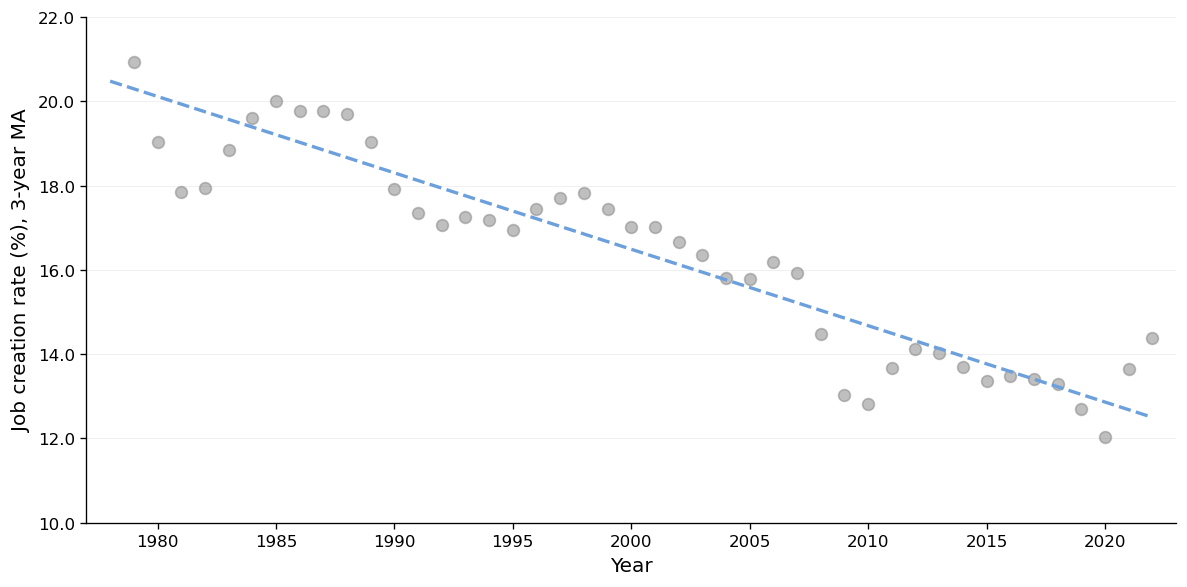

In [17]:
X = df_plot[['year']].values
y = df_plot['job_creation_rate_3yr_avg'].values
model = LinearRegression().fit(X, y)
y_trend = model.predict(X)

plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
ax.set_facecolor('white')

ax.scatter(
    df_plot['year'],
    y,
    s=50,
    color='grey',
    alpha=0.5,
)

ax.plot(
    df_plot['year'],
    y_trend,
    linestyle='--',
    linewidth=2,
    color='#6CA0DC',
)

min_year = df_plot['year'].min()
max_year = df_plot['year'].max()
start_year = min_year - (min_year % 5)
if start_year < min_year:
    start_year += 5
    
x_ticks = range(start_year, max_year + 6, 5)

ax.set_xticks(x_ticks)
ax.set_ylim(10, 22)
y_ticks = range(10, 24, 2) 
ax.set_yticks(y_ticks)
ax.yaxis.set_major_formatter('{x:.1f}') 
ax.set_xlim(min_year - 1, max_year + 1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8) 
ax.spines['bottom'].set_linewidth(0.8)  

ax.grid(which='major', axis='y', linestyle='-', linewidth=0.4, color='#E0E0E0', alpha=0.7)
ax.set_axisbelow(True) 

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Job creation rate (%), 3-year MA', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('../figures/job_creation_rate_trend.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
df_plot = (
    merged
      .groupby('year')[ 'job_destruction_rate_3yr_avg' ]
      .mean()
      .reset_index()
)

In [133]:
X = df_plot[['year']].values
y = df_plot['job_destruction_rate_3yr_avg'].values
model = LinearRegression().fit(X, y)
y_trend = model.predict(X)

plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
ax.set_facecolor('white')

ax.scatter(
    df_plot['year'],
    y,
    s=50,
    color='grey',
    alpha=0.5,
)

ax.plot(
    df_plot['year'],
    y_trend,
    linestyle='--',
    linewidth=2,
    color='#E41A1C',  
)

min_year = df_plot['year'].min()
max_year = df_plot['year'].max()
start_year = min_year - (min_year % 5)
if start_year < min_year:
    start_year += 5
x_ticks = range(start_year, max_year + 6, 5)
ax.set_xticks(x_ticks)

ax.set_ylim(10, 22)

y_ticks = range(10, 24, 2) 
ax.set_yticks(y_ticks)
ax.yaxis.set_major_formatter('{x:.1f}')  
ax.set_xlim(min_year - 1, max_year + 1)

# 9) Single-axis "spine" style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)  
ax.spines['bottom'].set_linewidth(0.8)  

ax.grid(which='major', axis='y', linestyle='-', linewidth=0.4, color='#E0E0E0', alpha=0.7)
ax.set_axisbelow(True)  

# 11) Labels only on the axes (no title, no legend)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Job destruction rate (%), 3-year MA', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('../figures/job_destruction_rate_trend.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'df_plot' is not defined

In [20]:
df_plot = (
    merged
      .groupby('year')[ 'reallocation_rate_3yr_avg' ]
      .mean()
      .reset_index()
)

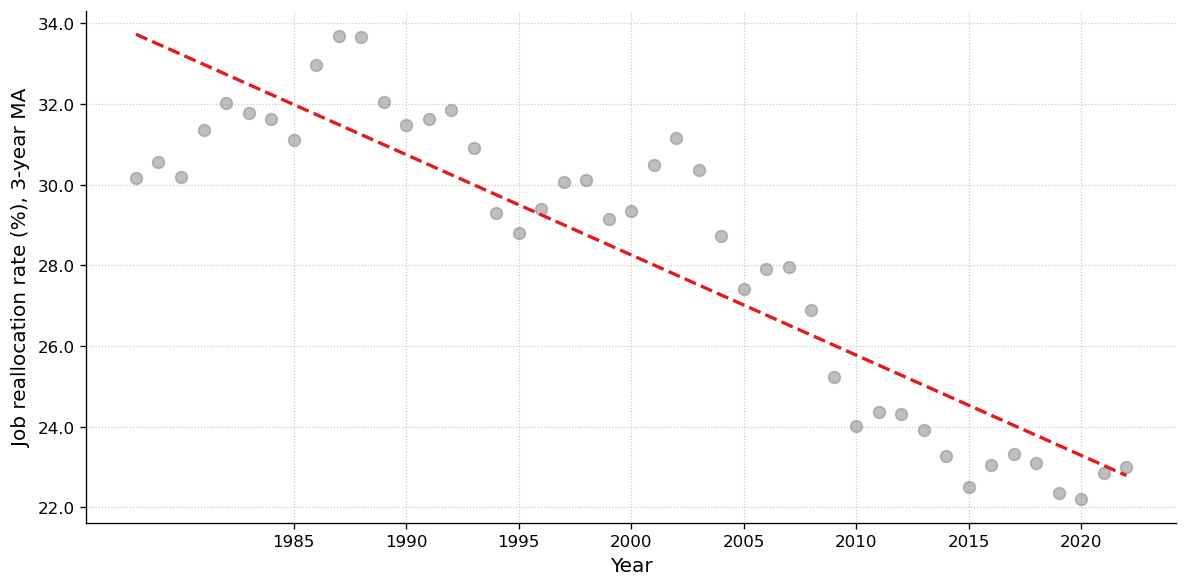

In [21]:
X = df_plot[['year']].values
y = df_plot['reallocation_rate_3yr_avg'].values
model = LinearRegression().fit(X, y)
y_trend = model.predict(X)

plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
ax.set_facecolor('white')

ax.scatter(
    df_plot['year'],
    y,
    s=50,
    color='grey',
    alpha=0.5,
)

ax.plot(
    df_plot['year'],
    y_trend,
    linestyle='--',
    linewidth=2,
    color='#E41A1C')

y_min = np.floor(y.min())
y_max = np.ceil(y.max())
y_range = y_max - y_min
 
if y_range <= 5:
    tick_spacing = 0.5  # For small ranges
elif y_range <= 10:
    tick_spacing = 1.0  # For medium ranges
else:
    tick_spacing = 2.0  # For large ranges

y_ticks = np.arange(y_min, y_max + tick_spacing, tick_spacing)
ax.set_yticks(y_ticks)
ax.yaxis.set_major_formatter('{x:.1f}')  # show one decimal place

ax.set_xticks(range(1985, df_plot['year'].max()+1, 5))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
ax.set_axisbelow(True)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Job reallocation rate (%), 3-year MA', fontsize=12)

plt.tight_layout()
plt.savefig('../figures/job_reallocation_rate_trend.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
print(merged.columns)

Index(['year', 'NAICS', 'firms', 'estabs', 'emp', 'denom', 'estabs_entry',
       'estabs_entry_rate', 'estabs_exit', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers',
       'job_creation_rate_births', 'job_creation_rate', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'job_destruction_rate_deaths', 'job_destruction_rate',
       'net_job_creation', 'net_job_creation_rate', 'reallocation_rate',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp',
       'firms_percent_destroyed', 'job_creation_rate_3yr_avg',
       'job_destruction_rate_3yr_avg', 'reallocation_rate_3yr_avg',
       'estabs_entry_rate_3yr_avg', 'estabs_exit_rate_3yr_avg',
       'firms_percent_destroyed_3yr_avg'],
      dtype='object')


In [23]:
df_plot = (
    merged
    .groupby('year')
    .agg({
        'estabs_exit_rate_3yr_avg': 'mean'  # or the appropriate column name for firm death rate
    })
    .reset_index()
)

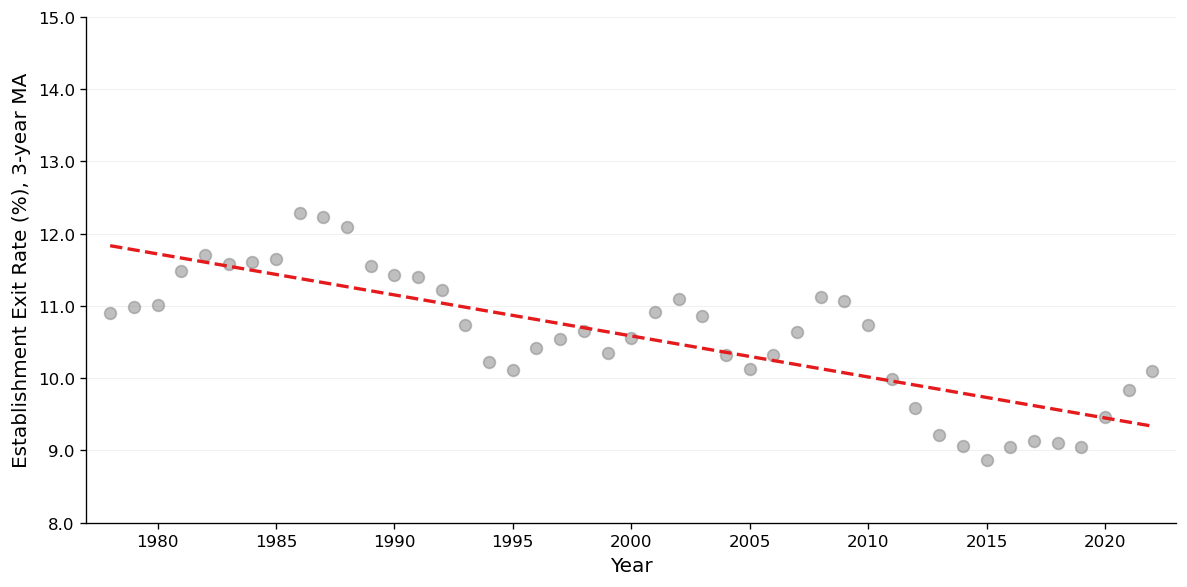

In [25]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
ax.set_facecolor('white')

X = df_plot[['year']].values
years = df_plot['year']

ax.scatter(
    years,
    df_plot['estabs_exit_rate_3yr_avg'],
    s=50,
    color='grey',
    alpha=0.5
)

y_estab = df_plot['estabs_exit_rate_3yr_avg'].values
model_estab = LinearRegression().fit(X, y_estab)
y_estab_trend = model_estab.predict(X)

ax.plot(
    years,
    y_estab_trend,
    linestyle='--',
    linewidth=2,
    color='#E41A1C'  
)

min_year = min(years)
max_year = max(years)

start_year = 1980
x_ticks = range(start_year, max_year + 6, 5)
ax.set_xticks(x_ticks)
ax.set_xlim(min_year - 1, max_year + 1) 
ax.set_ylim(8, 15)

y_ticks = np.arange(8, 15.1, 1.0) 
ax.set_yticks(y_ticks)
ax.yaxis.set_major_formatter('{x:.1f}')  

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Establishment Exit Rate (%), 3-year MA', fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8) 
ax.spines['bottom'].set_linewidth(0.8) 
ax.grid(which='major', axis='y', linestyle='-', linewidth=0.4, color='#E0E0E0', alpha=0.7)
ax.set_axisbelow(True) 
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('../figures/estabs_exit_rate_trend.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df_plot = (
    merged
    .groupby('year')
    .agg({
        'estabs_entry_rate_3yr_avg': 'mean'  # or the appropriate column name for firm death rate
    })
    .reset_index()
)

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
ax.set_facecolor('white')

X = df_plot[['year']].values
years = df_plot['year']

ax.scatter(
    years,
    df_plot['estabs_entry_rate_3yr_avg'],
    s=50,
    color='grey',
    alpha=0.5
)

y_estab = df_plot['estabs_entry_rate_3yr_avg'].values
model_estab = LinearRegression().fit(X, y_estab)
y_estab_trend = model_estab.predict(X)

ax.plot(
    years,
    y_estab_trend,
    linestyle='--',
    linewidth=2,
    color='#6CA0DC'
)

min_year = min(years)
max_year = max(years)

start_year = 1980
x_ticks = range(start_year, max_year + 6, 5)
ax.set_xticks(x_ticks)
ax.set_xlim(min_year - 1, max_year + 1)  

ax.set_ylim(8, 15)

y_ticks = np.arange(8, 15.1, 1.0)  # 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0
ax.set_yticks(y_ticks)
ax.yaxis.set_major_formatter('{x:.1f}') 

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Establishment Entry Rate (%), 3-year MA', fontsize=12)

# Improve spine appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

# Improve gridlines (lighter, horizontal only)
ax.grid(which='major', axis='y', linestyle='-', linewidth=0.4, color='#E0E0E0', alpha=0.7)
ax.set_axisbelow(True)

ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('../figures/estabs_entry_rate_trend.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df_plot = (
    merged
    .groupby('year')
    .agg({
        'firms_percent_destroyed_3yr_avg': 'mean'  # or the appropriate column name for firm death rate
    })
    .reset_index()
)

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
ax.set_facecolor('white')

X = df_plot[['year']].values
years = df_plot['year']

ax.scatter(
    years,
    df_plot['firms_percent_destroyed_3yr_avg'],
    s=50,
    color='grey',
    alpha=0.5
)

y_firm = df_plot['firms_percent_destroyed_3yr_avg'].values
model_firm = LinearRegression().fit(X, y_firm)
y_firm_trend = model_firm.predict(X)

ax.plot(
    years,
    y_firm_trend,
    linestyle='--',
    linewidth=2,
    color='#E41A1C' 
)

min_year = min(years)
max_year = max(years)

start_year = 1980
x_ticks = range(start_year, max_year + 6, 5)
ax.set_xticks(x_ticks)
ax.set_xlim(min_year - 1, max_year + 1)  

ax.set_ylim(6, 14)

y_ticks = np.arange(6, 14.1, 1.0)  
ax.set_yticks(y_ticks)
ax.yaxis.set_major_formatter('{x:.1f}')  

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Firm Death Rate (%), 3-year MA', fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)  
ax.spines['bottom'].set_linewidth(0.8) 

ax.grid(which='major', axis='y', linestyle='-', linewidth=0.4, color='#E0E0E0', alpha=0.7)
ax.set_axisbelow(True)  # Ensure grid is behind data


ax.tick_params(axis='both', which='major', labelsize=10)


plt.tight_layout()
plt.savefig('../figures/firm_death_rate_trend.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
data_path = "../raw_data/dynamism_data/new_firms_df.csv"
new_firms = pd.read_csv(data_path)

In [ ]:

new_firms['new_firm_rate_3yr_avg'] = (
    new_firms
    .sort_values('year')
    .new_firm_rate
    .rolling(window=3, min_periods=1, center=True)
    .mean()
)

X = new_firms[['year']].values
y = new_firms['new_firm_rate_3yr_avg'].values

model = LinearRegression().fit(X, y)
y_trend = model.predict(X)

plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
ax.set_facecolor('white')

ax.scatter(
    new_firms['year'],
    y,
    s=50,
    color='grey',
    alpha=0.5,
)

ax.plot(
    new_firms['year'],
    y_trend,
    linestyle='--',
    linewidth=2,
    color='#6CA0DC',
)

min_year = new_firms['year'].min()
max_year = new_firms['year'].max()

start_year = 1980
x_ticks = range(start_year, int(max_year) + 6, 5)
ax.set_xticks(x_ticks)
ax.set_xlim(min_year - 1, max_year + 1)  # Add padding

ax.set_ylim(6, 14)

y_ticks = np.arange(6, 14.1, 1.0) 
ax.set_yticks(y_ticks)
ax.yaxis.set_major_formatter('{x:.1f}')  

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)  
ax.spines['bottom'].set_linewidth(0.8)  

ax.grid(which='major', axis='y', linestyle='-', linewidth=0.4, color='#E0E0E0', alpha=0.7)
ax.set_axisbelow(True)  

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Firm birth rate (%), 3-year MA', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('../figures/firm_birth_rate_trend.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
vars = [
    'job_creation_rate',
    'job_destruction_rate',
    'reallocation_rate', 
    'estabs_entry_rate', 
    'estabs_exit_rate', 
    'firms_percent_destroyed'
]

for var in vars:
    merged[f'{var}_2yr_avg'] = (
        merged
          .sort_values(['NAICS','year'])
          .groupby('NAICS')[var]
          .rolling(window=2, min_periods=1, center=True)
          .mean()
          .reset_index(level=0, drop=True)
    )

In [ ]:

def weighted_avg(values, weights):
    values = pd.to_numeric(values, errors='coerce')
    weights = pd.to_numeric(weights, errors='coerce')

    mask = ~(np.isnan(values) | np.isnan(weights))
    values = values[mask]
    weights = weights[mask]
    
    return np.average(values, weights=weights) if len(values) > 0 else np.nan

national = pd.DataFrame()
for year, group in merged.groupby("year"):
    firm_entry = weighted_avg(
        group["job_creation_rate_3yr_avg"], 
        group["weight"]
    )
    estab_entry = weighted_avg(
        group["estabs_entry_rate_3yr_avg"], 
        group["weight"]
    )
    
    national = pd.concat([
        national, 
        pd.DataFrame({
            "year": [year],
            "firm_entry_wt": [firm_entry],
            "estab_entry_wt": [estab_entry]
        })
    ])

national = national.reset_index(drop=True).sort_values("year")

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(
    national["year"],
    national["firm_entry_wt"],
    linestyle="-",  
    linewidth=2.5,
    color="#4993C3",
    label="Firms"
)
ax1.set_ylabel("Firm entry rate (%)", fontsize=11)
ax1.set_xlabel("Year", fontsize=11)

y_min = 8 
y_max = 19 
ax1.set_ylim(y_min, y_max)
ax1.set_xlim(national["year"].min(), national["year"].max())

ax2 = ax1.twinx()
ax2.plot(
    national["year"],
    national["estab_entry_wt"],
    linestyle="--", 
    linewidth=2.5,
    color="#4993C3",  
    label="Establishments"
)
ax2.set_ylabel("Establishment entry rate (%)", fontsize=11)
ax2.set_ylim(y_min, y_max) 

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper right", frameon=False)

ax1.grid(True, linestyle='-', color='lightgray', alpha=0.5)

ax1.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)

for spine in ["bottom", "left", "right"]:
    ax1.spines[spine].set_visible(True)
    ax2.spines[spine].set_visible(True)

ax1.set_yticks(range(8, 20, 2))  # 8, 10, 12, 14, 16, 18
ax2.set_yticks(range(8, 20, 2))  # Match left axis

plt.tight_layout()
plt.show()

### Productivity Trends

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
import os

df = pd.read_csv('../processed_data/two_digit_NAICS_bds_tfp.csv')

In [4]:
df.columns

Index(['year', 'NAICS', 'firms', 'estabs', 'emp', 'denom', 'estabs_entry',
       'estabs_entry_rate', 'estabs_exit', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers',
       'job_creation_rate_births', 'job_creation_rate', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'job_destruction_rate_deaths', 'job_destruction_rate',
       'net_job_creation', 'net_job_creation_rate', 'reallocation_rate',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp', 'Industry',
       'Basis', 'weight', 'tfp_pct_change', 'tfp_index_2017',
       'firms_percent_destroyed'],
      dtype='object')

In [5]:
df['tfp_index_2017'] = pd.to_numeric(df['tfp_index_2017'], errors='coerce')
df['tfp_pct_change'] = pd.to_numeric(df['tfp_pct_change'], errors='coerce')

df_plot = (
    df
      .groupby(['NAICS', 'year'])
      .agg({
          'tfp_index_2017': 'mean',
          'tfp_pct_change': 'mean'
      })
      .reset_index()
)

if 'weight' in df.columns:
    # Calculate average weight by NAICS and year
    weights_df = (
        df
        .groupby(['NAICS', 'year'])['weight']
        .mean()
        .reset_index()
    )
    
    df_plot = pd.merge(
        df_plot,
        weights_df,
        on=['NAICS', 'year'],
        how='left'
    )

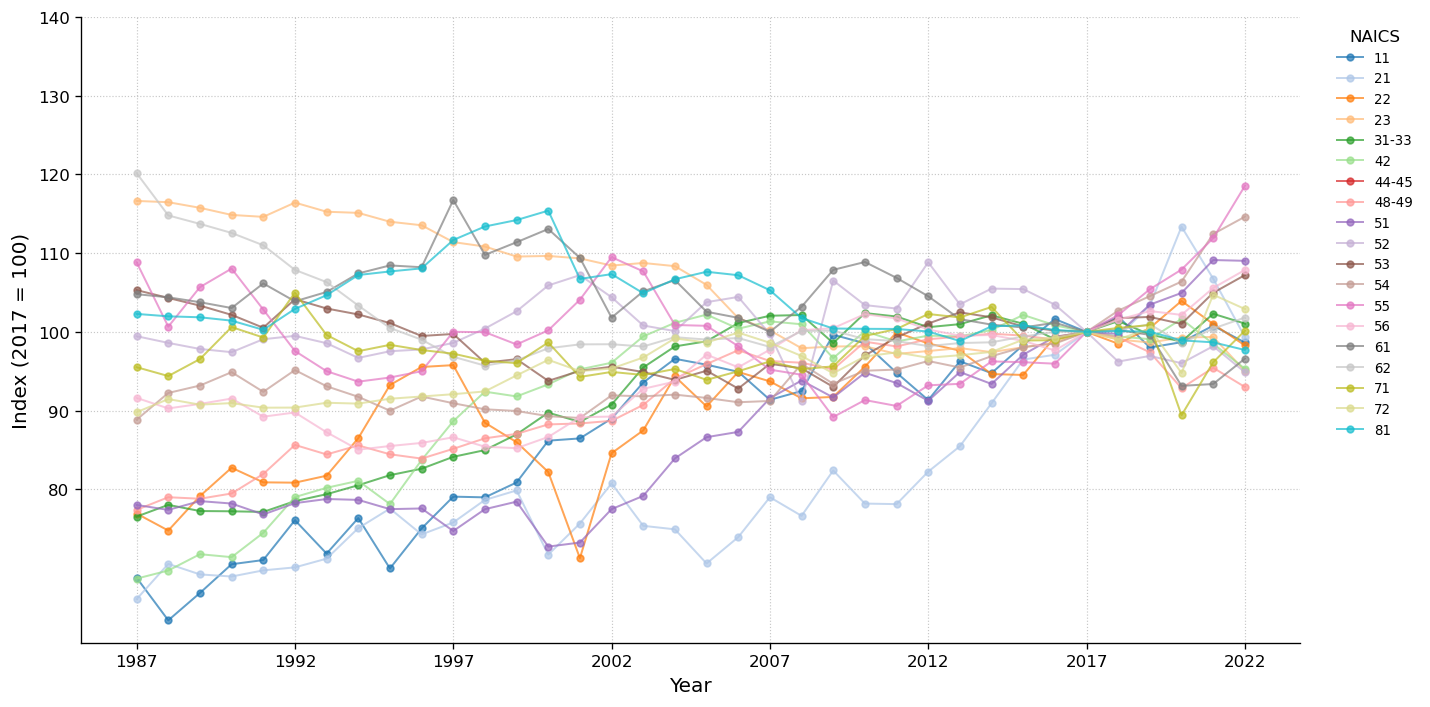

In [6]:
fig, ax = plt.subplots(figsize=(12,6), dpi=120)
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
ax.set_axisbelow(True)

cmap = plt.get_cmap('tab20')

naics_codes = df_plot['NAICS'].unique()
for i, code in enumerate(naics_codes):
    sub = df_plot[df_plot['NAICS'] == code]
    ax.plot(
        sub['year'],
        sub['tfp_index_2017'],
        label=str(code),
        color=cmap(i % 20),
        linewidth=1.2,
        alpha=0.7,
        marker='o',
        markersize=4
    )

ax.set_xticks(range(df_plot['year'].min(), df_plot['year'].max()+1, 5))
ax.set_yticks(range(80, 141, 10))
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Index (2017 = 100)', fontsize=12)

ax.legend(
    title='NAICS',
    bbox_to_anchor=(1.02,1),
    loc='upper left',
    fontsize=8,
    frameon=False
)

plt.tight_layout()
plt.show()

In [7]:
df_plot.head(5)

NAICS  year  tfp_index_2017  tfp_pct_change    weight
0    11  1987          68.776             NaN  0.009333
1    11  1988          63.369            -7.9  0.008802
2    11  1989          66.843             5.5  0.008845
3    11  1990          70.492             5.5  0.008622
4    11  1991          71.025             0.8  0.008256

In [8]:
aggregate_tfp = (
    df_plot.dropna(subset=['tfp_index_2017', 'weight'])
    .groupby('year')
    .apply(lambda x: np.average(x['tfp_index_2017'], weights=x['weight']))
    .reset_index()
    .rename(columns={0: 'weighted_tfp'})
)

C:\Users\Lamb\AppData\Local\Temp\ipykernel_21804\2718380993.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['tfp_index_2017'], weights=x['weight']))


In [9]:
aggregate_tfp.head(5)

year  weighted_tfp
0  1987     88.469078
1  1988     88.536818
2  1989     88.653566
3  1990     88.904343
4  1991     88.697883

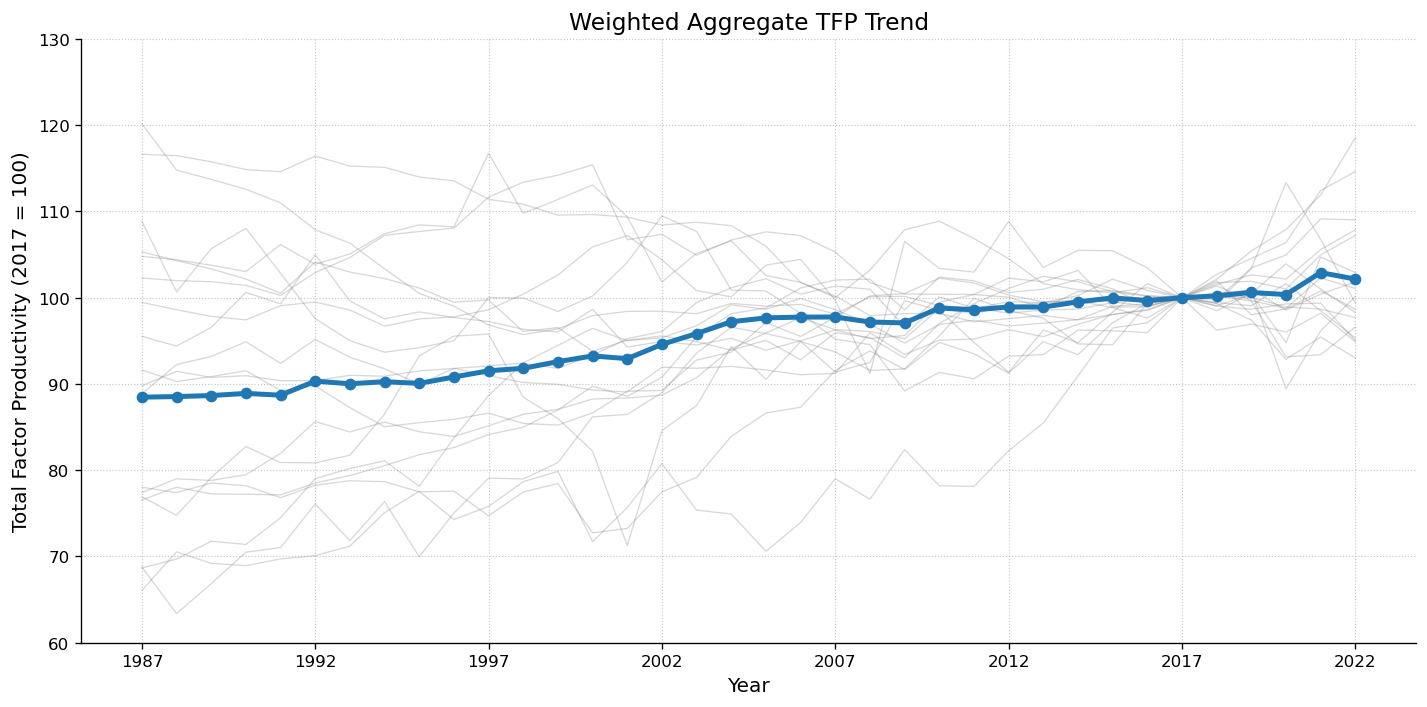

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
ax.set_axisbelow(True)

naics_codes = df_plot['NAICS'].unique()
for code in naics_codes:
    sub = df_plot[df_plot['NAICS'] == code]
    ax.plot(
        sub['year'],
        sub['tfp_index_2017'],
        color='grey',
        linewidth=0.8,
        alpha=0.3,
        marker='',  
    )

ax.plot(
    aggregate_tfp['year'],
    aggregate_tfp['weighted_tfp'],
    label='Weighted Aggregate TFP',
    color='#1f77b4', 
    linewidth=3.0,    
    alpha=1.0,
    marker='o',
    markersize=6,   
    zorder=10        
)

ax.set_xticks(range(df_plot['year'].min(), df_plot['year'].max()+1, 5))

y_min = np.floor(min(df_plot['tfp_index_2017'].min(), aggregate_tfp['weighted_tfp'].min()) / 10) * 10
y_max = np.ceil(max(df_plot['tfp_index_2017'].max(), aggregate_tfp['weighted_tfp'].max()) / 10) * 10
ax.set_yticks(range(int(y_min), int(y_max)+1, 10))

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Factor Productivity (2017 = 100)', fontsize=12)

os.makedirs('../figures', exist_ok=True)  
plt.tight_layout()
plt.savefig('../figures/weighted_tfp_trends.png', dpi=300, bbox_inches='tight')
plt.show()

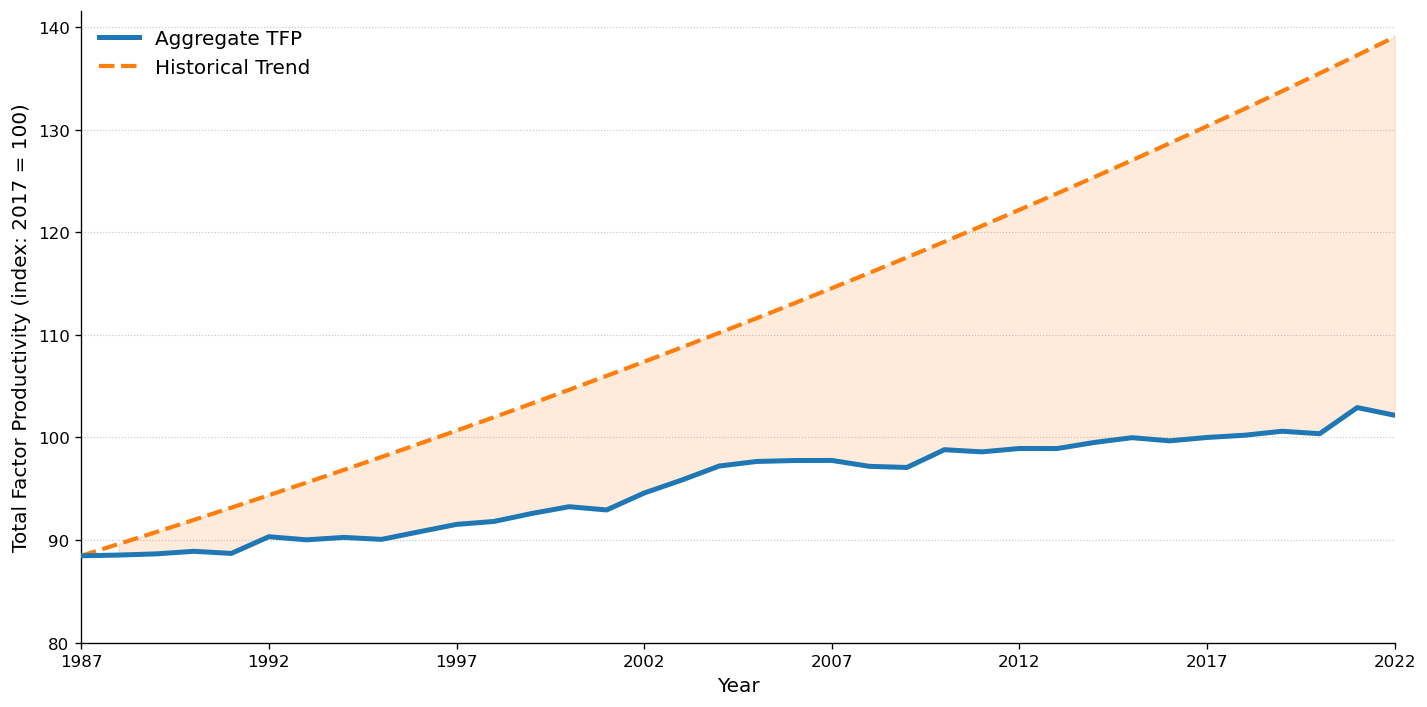

In [27]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('axes', 0.0))

ax.grid(which='major', axis='y', linestyle=':', linewidth=0.7, alpha=0.7)
ax.margins(x=0)
ax.set_axisbelow(True)

df_plot_clean = df_plot.dropna(subset=['tfp_index_2017'])
aggregate_tfp_clean = aggregate_tfp.dropna(subset=['weighted_tfp'])

years = aggregate_tfp_clean['year'].values
tfp_values = aggregate_tfp_clean['weighted_tfp'].values

ax.plot(
    years,
    tfp_values,
    color='#1f77b4',
    linewidth=3.0,
    alpha=1.0,
    zorder=10,
    label='Aggregate TFP'   
)

if len(years) > 0:  
    historical_start = tfp_values[0] 
    historical_values = []
    
    for year in range(int(years.min()), int(years.max())+1):
        years_from_start = year - years.min()
        historical_values.append(historical_start * (1 + 1.3/100) ** years_from_start)
    
    year_range = range(int(years.min()), int(years.max())+1)
    
    ax.plot(
        year_range,
        historical_values,
        '--',
        linewidth=2.5,
        color='#ff7f0e',
        zorder=5,
        label='Historical Trend' 
    )

    # shade in
    interp_actual = np.interp(year_range, years, tfp_values)
    ax.fill_between(
        year_range,
        interp_actual,
        historical_values,
        where=[hv > tv for hv, tv in zip(historical_values, interp_actual)],
        color='#ff7f0e',
        alpha=0.15
    )

if len(years) > 0:
    ax.set_xticks(range(int(years.min()), int(years.max())+1, 5))
    
    all_values = np.concatenate([tfp_values, historical_values])
    y_min = np.floor(min(all_values) / 10) * 10
    y_max = np.ceil(max(all_values) / 10) * 10
    ax.set_yticks(range(int(y_min), int(y_max)+1, 10))

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Factor Productivity (index: 2017 = 100)', fontsize=12)
ax.legend(loc='upper left', frameon=False, fontsize=12)

os.makedirs('../figures', exist_ok=True)
plt.tight_layout()
plt.savefig('../figures/tfp_productivity_slowdown.png', dpi=300, bbox_inches='tight')
plt.show()

Bar chart of weighted average TFP percent change by year.

Data to be plotted:
    year  weighted_tfp_change
0   1988             0.228830
1   1989             0.212520
2   1990             0.246616
3   1991            -0.227970
4   1992             1.822523
5   1993            -0.257658
6   1994             0.447023
7   1995            -0.090773
8   1996             0.861642
9   1997             0.872058
10  1998             0.240650
11  1999             0.862551
12  2000             0.628931
13  2001            -0.454634
14  2002             1.850541
15  2003             1.430500
16  2004             1.482630
17  2005             0.512292
18  2006             0.142916
19  2007             0.163018
20  2008            -0.411440
21  2009             0.006729
22  2010             1.874251
23  2011            -0.178486
24  2012             0.379813
25  2013             0.121657
26  2014             0.644240
27  2015             0.442893
28  2016            -0.286120
29  2017             0.376780
30  2018             0.216447
31  2019            

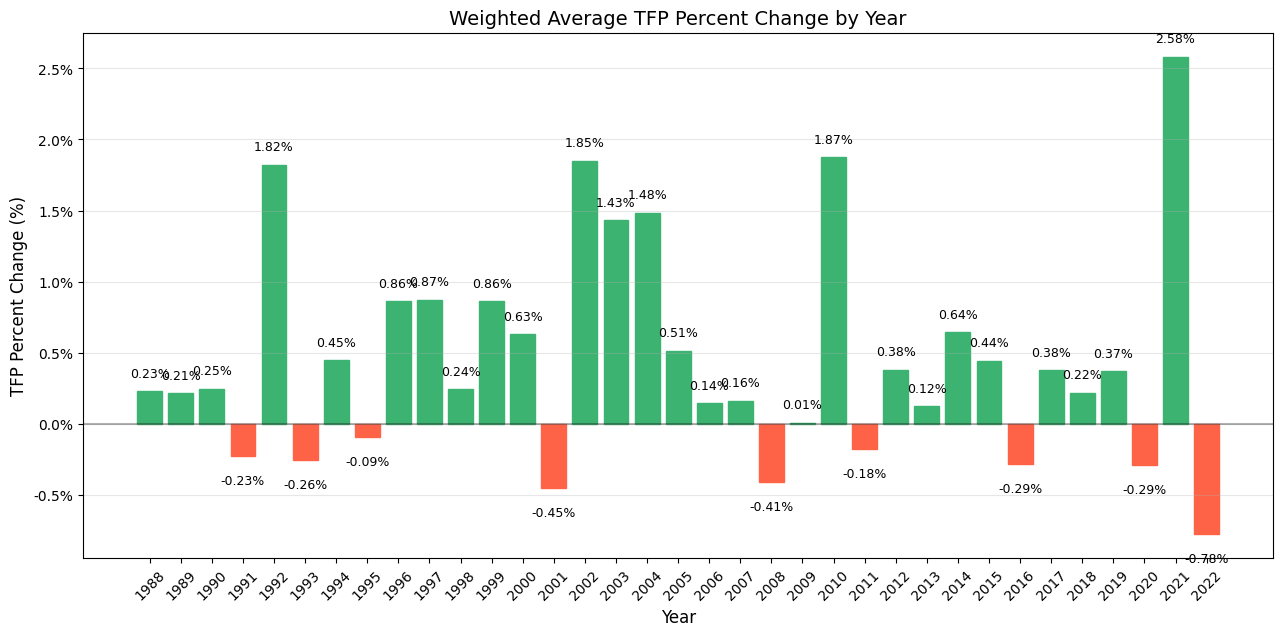

In [18]:
def plot_weighted_tfp_by_year(df):
    df = df.copy()
    
    # Convert columns to numeric, replacing non-numeric values with NaN
    df['tfp_pct_change'] = pd.to_numeric(df['tfp_pct_change'], errors='coerce')
    df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
    
    # Drop rows with NaN in these columns
    df = df.dropna(subset=['tfp_pct_change', 'weight'])
    
    # Calculate weighted average manually by year
    yearly_data = []
    for year in sorted(df['year'].unique()):
        year_data = df[df['year'] == year]
        
        # Manual weighted average calculation
        weighted_sum = (year_data['tfp_pct_change'] * year_data['weight']).sum()
        weight_sum = year_data['weight'].sum()
        
        if weight_sum > 0:  # Avoid division by zero
            weighted_avg = weighted_sum / weight_sum
            yearly_data.append({'year': year, 'weighted_tfp_change': weighted_avg})
    
    yearly_tfp = pd.DataFrame(yearly_data)
    
    # Print the data we'll be plotting
    print("Data to be plotted:")
    print(yearly_tfp)
    
    # Create the plot with adequate figure size
    plt.figure(figsize=(14, 7))
    
    # Get x positions - use integers for bar positions
    x_pos = list(range(len(yearly_tfp)))
    
    # Create the bars using integer positions (no multiplication by 100)
    bars = plt.bar(x_pos, yearly_tfp['weighted_tfp_change'])
    
    # Color the bars based on positive/negative values
    for i, bar in enumerate(bars):
        if yearly_tfp['weighted_tfp_change'].iloc[i] < 0:
            bar.set_color('tomato')
        else:
            bar.set_color('mediumseagreen')
    
    # Add a horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add labels and title
    plt.title('Weighted Average TFP Percent Change by Year', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('TFP Percent Change (%)', fontsize=12)
    
    # Format y-axis labels with percentage sign
    from matplotlib.ticker import FuncFormatter
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))
    
    # Add grid lines for readability
    plt.grid(axis='y', alpha=0.3)
    
    # Set x-ticks to be at the bar positions, but labeled with years
    plt.xticks(x_pos, yearly_tfp['year'].astype(str), rotation=45)
    
    # Add data labels with adjusted positioning
    for i, v in enumerate(yearly_tfp['weighted_tfp_change']):
        # Adjust vertical offset based on value
        offset = 0.1 if v >= 0 else -0.2
        plt.text(i, v + offset, f'{v:.2f}%', ha='center', fontsize=9)
    
    # Adjust layout with specific margins
    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9)
    
    # Show the plot
    plt.show()
    
    return yearly_tfp

# Example usage:
yearly_tfp = plot_weighted_tfp_by_year(df)

Data to be plotted:
    year  weighted_tfp_change
0   1988             0.228830
1   1989             0.212520
2   1990             0.246616
3   1991            -0.227970
4   1992             1.822523
5   1993            -0.257658
6   1994             0.447023
7   1995            -0.090773
8   1996             0.861642
9   1997             0.872058
10  1998             0.240650
11  1999             0.862551
12  2000             0.628931
13  2001            -0.454634
14  2002             1.850541
15  2003             1.430500
16  2004             1.482630
17  2005             0.512292
18  2006             0.142916
19  2007             0.163018
20  2008            -0.411440
21  2009             0.006729
22  2010             1.874251
23  2011            -0.178486
24  2012             0.379813
25  2013             0.121657
26  2014             0.644240
27  2015             0.442893
28  2016            -0.286120
29  2017             0.376780
30  2018             0.216447
31  2019            

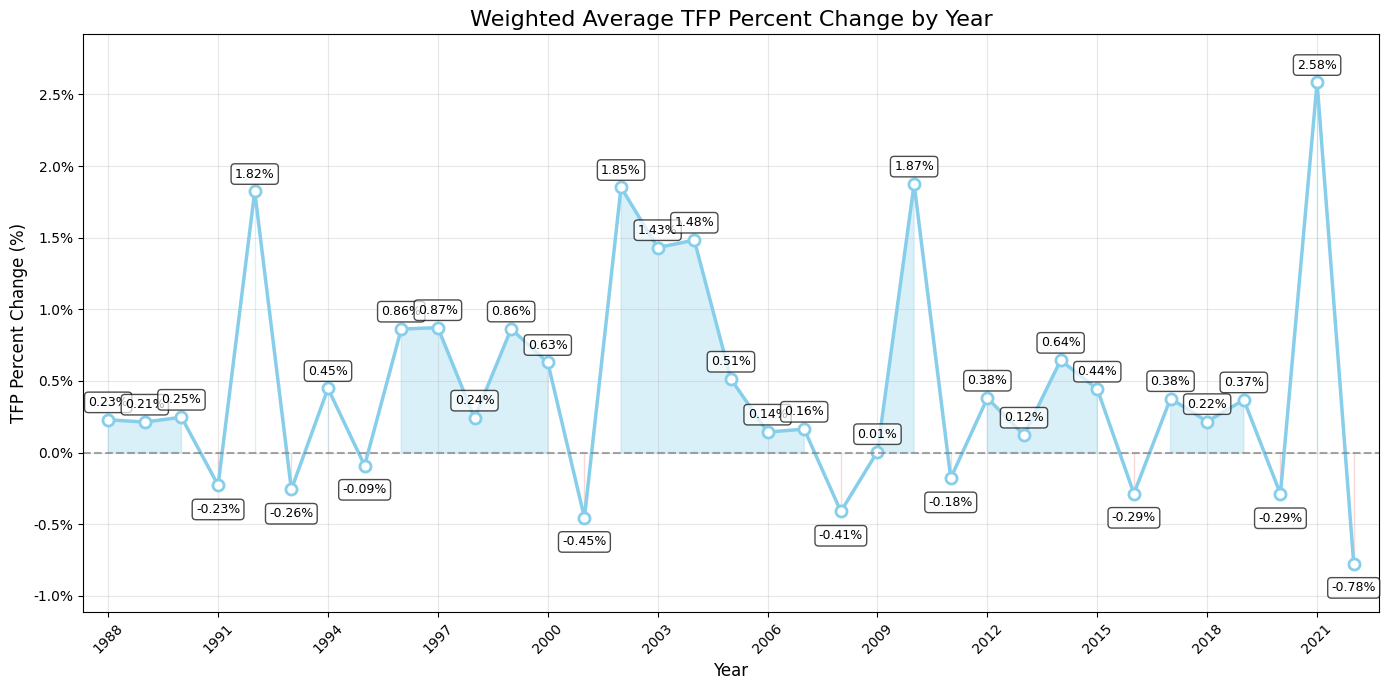

In [16]:
def plot_weighted_tfp_line(df):
    """
    Create a line plot of weighted average TFP percent change by year.
    Values in tfp_pct_change are already in percentage form.
    """
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Convert columns to numeric, replacing non-numeric values with NaN
    df['tfp_pct_change'] = pd.to_numeric(df['tfp_pct_change'], errors='coerce')
    df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
    
    # Drop rows with NaN in these columns
    df = df.dropna(subset=['tfp_pct_change', 'weight'])
    
    # Calculate weighted average manually by year
    yearly_data = []
    for year in sorted(df['year'].unique()):
        year_data = df[df['year'] == year]
        
        # Manual weighted average calculation
        weighted_sum = (year_data['tfp_pct_change'] * year_data['weight']).sum()
        weight_sum = year_data['weight'].sum()
        
        if weight_sum > 0:  # Avoid division by zero
            weighted_avg = weighted_sum / weight_sum
            yearly_data.append({'year': year, 'weighted_tfp_change': weighted_avg})
    
    yearly_tfp = pd.DataFrame(yearly_data)
    
    # Print the data we'll be plotting
    print("Data to be plotted:")
    print(yearly_tfp)
    
    # Create the plot with adequate figure size
    plt.figure(figsize=(14, 7))
    
    # Create a light blue line plot with markers
    plt.plot(
        yearly_tfp['year'], 
        yearly_tfp['weighted_tfp_change'],
        marker='o',                # Add circle markers at each data point
        linestyle='-',            # Solid line
        linewidth=2.5,            # Slightly thicker line
        color='skyblue',          # Light blue color
        markerfacecolor='white',  # White fill for markers
        markeredgecolor='skyblue', # Light blue edge for markers
        markeredgewidth=2,        # Slightly thicker marker edge
        markersize=8              # Marker size
    )
    
    # Add a horizontal line at y=0
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    
    # Fill area between line and y=0 with light colors
    plt.fill_between(
        yearly_tfp['year'],
        yearly_tfp['weighted_tfp_change'],
        0,
        where=(yearly_tfp['weighted_tfp_change'] >= 0),
        color='skyblue',
        alpha=0.3
    )
    plt.fill_between(
        yearly_tfp['year'],
        yearly_tfp['weighted_tfp_change'],
        0,
        where=(yearly_tfp['weighted_tfp_change'] < 0),
        color='lightcoral',
        alpha=0.3
    )
    
    # Add labels and title
    plt.title('Weighted Average TFP Percent Change by Year', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('TFP Percent Change (%)', fontsize=12)
    
    # Format y-axis labels with percentage sign
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))
    
    # Add grid lines for readability
    plt.grid(True, alpha=0.3)
    
    # Set x-axis tick frequency - show fewer years if there are many
    num_years = len(yearly_tfp)
    step = max(1, num_years // 10)  # Show about 10 year labels
    
    plt.xticks(
        yearly_tfp['year'][::step],  # Show every nth year
        yearly_tfp['year'][::step],
        rotation=45
    )
    
    # Add data labels for each point
    for i, row in yearly_tfp.iterrows():
        x = row['year']
        y = row['weighted_tfp_change']
        
        # Position labels above positive values, below negative values
        offset = 0.15 if y >= 0 else -0.25
        
        plt.annotate(
            f'{y:.2f}%',
            (x, y),
            textcoords="offset points", 
            xytext=(0, 10 if y >= 0 else -20),
            ha='center',
            fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7)
        )
    
    # Adjust plot limits to make room for labels
    plt.margins(x=0.02, y=0.1)
    
    # Adjust layout with specific margins
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    return yearly_tfp

# Example usage:
yearly_tfp = plot_weighted_tfp_line(df)


/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_24161/621715863.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['tfp_pct_change'] * x['norm_weight']).sum())  # Changed to tfp_pct_change


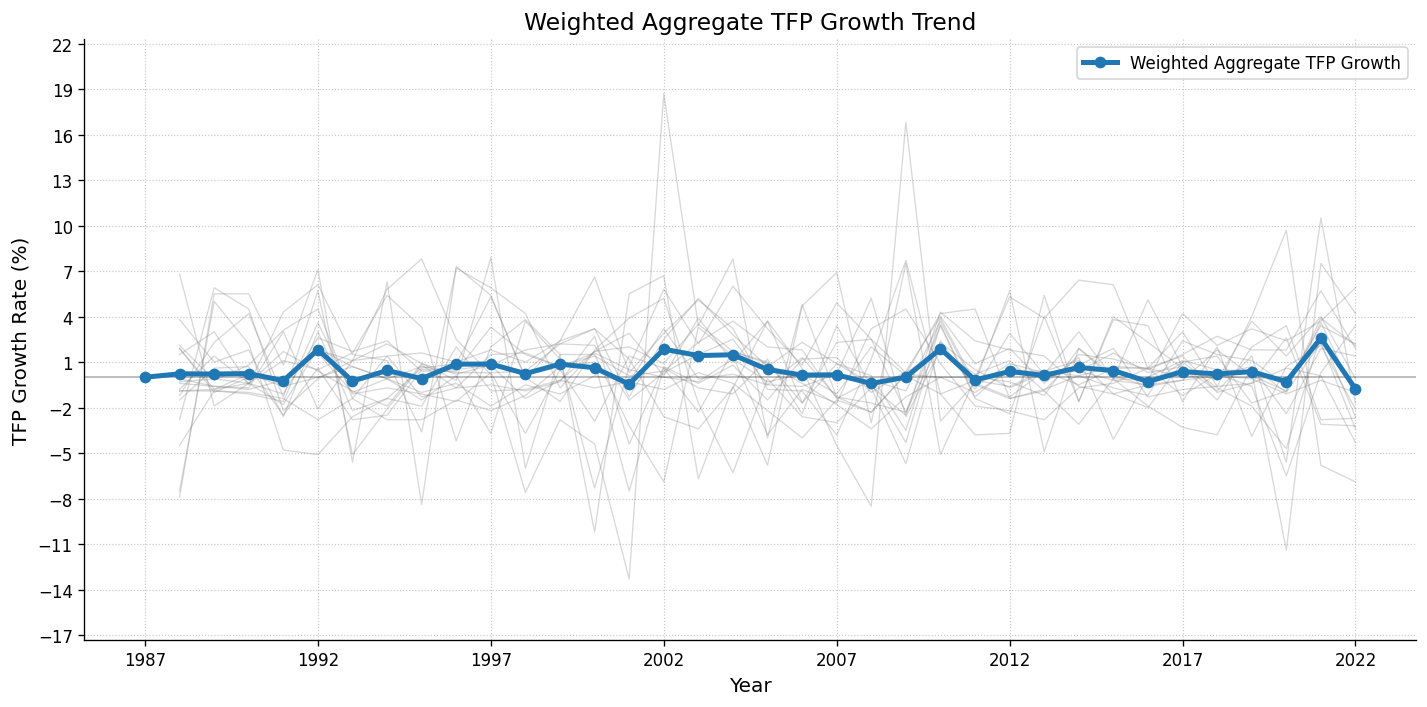

In [17]:
# 4) Set up the figure
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
ax.set_axisbelow(True)

# 5) Plot all NAICS trends in grey (semi-transparent)
naics_codes = df_plot['NAICS'].unique()
for code in naics_codes:
    sub = df_plot[df_plot['NAICS'] == code]
    ax.plot(
        sub['year'],
        sub['tfp_pct_change'],  # Changed to tfp_pct_change
        color='grey',
        linewidth=0.8,
        alpha=0.3,
        marker='',  # No markers for individual series to reduce clutter
    )

# 6) Plot the weighted aggregate TFP growth in blue (bold)
# First, calculate the weighted aggregate TFP growth
aggregate_growth = df_plot.copy()
if 'weight' in aggregate_growth.columns:
    # Ensure weight is normalized within each year
    aggregate_growth['norm_weight'] = aggregate_growth.groupby('year')['weight'].transform(
        lambda x: x / x.sum()
    )
    
    # Calculate weighted average by year
    weighted_growth = (
        aggregate_growth
        .groupby('year')
        .apply(lambda x: (x['tfp_pct_change'] * x['norm_weight']).sum())  # Changed to tfp_pct_change
        .reset_index(name='weighted_tfp_growth')  # Renamed to weighted_tfp_growth
    )
else:
    # If no weights, just take simple average
    weighted_growth = (
        df_plot
        .groupby('year')['tfp_pct_change']  # Changed to tfp_pct_change
        .mean()
        .reset_index(name='weighted_tfp_growth')  # Renamed to weighted_tfp_growth
    )

# Plot the weighted aggregate growth
ax.plot(
    weighted_growth['year'],
    weighted_growth['weighted_tfp_growth'],
    label='Weighted Aggregate TFP Growth',  # Updated label
    color='#1f77b4',  # Blue
    linewidth=3.0,
    alpha=1.0,
    marker='o',
    markersize=6,
    zorder=10
)

# 7) Ticks & labels
ax.set_xticks(range(df_plot['year'].min(), df_plot['year'].max()+1, 5))

# Dynamic y-ticks based on data range (for percentage changes)
y_min = np.floor(min(df_plot['tfp_pct_change'].min(), weighted_growth['weighted_tfp_growth'].min()))
y_max = np.ceil(max(df_plot['tfp_pct_change'].max(), weighted_growth['weighted_tfp_growth'].max()))
# Add some padding to y-axis
y_padding = (y_max - y_min) * 0.1
y_min -= y_padding
y_max += y_padding
ax.set_ylim(y_min, y_max)

# For percentage changes, we might want different tick spacing
tick_spacing = max(1, int((y_max - y_min) / 10))  # Aim for about 10 ticks
ax.set_yticks(np.arange(int(y_min), int(y_max)+1, tick_spacing))

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('TFP Growth Rate (%)', fontsize=12)  # Updated y-axis label
ax.set_title('Weighted Aggregate TFP Growth Trend', fontsize=14)  # Updated title

# Add horizontal line at y=0 to highlight positive vs negative growth
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)

# Add legend
ax.legend(loc='best', frameon=True, facecolor='white', framealpha=0.8)

# Save with relative path
plt.tight_layout()
plt.savefig('../figures/weighted_tfp_growth_trends.png', dpi=300, bbox_inches='tight')
plt.show()

## Regressions

### Productivity Trends Three Digit NAICS

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import product

In [2]:
df = pd.read_csv('../processed_data/three_digit_NAICS_final.csv')

year  NAICS  firms  estabs     emp   denom  estabs_entry  \
0  1987    211   7297    8942  130532  142230           909   
1  1987    212   6245    8515  285319  296796          1120   
2  1987    213   8315    9765  162956  193482          1262   
3  1987    321  14489   16107  517089  510664          1884   
4  1987    322   3683    5633  572571  572627           330   

   estabs_entry_rate  estabs_exit  estabs_exit_rate  ...        Basis  \
0              9.665         1836            19.520  ...  All workers   
1             13.007         1312            15.236  ...  All workers   
2             11.900         2942            27.742  ...  All workers   
3             11.717         1828            11.369  ...  All workers   
4              5.847          351             6.220  ...  All workers   

     weight  tfp_pct_change  tfp_index_2017  firms_percent_destroyed  \
0  0.023260             NaN          60.776                16.499931   
1  0.012166             NaN          86.967                12.281825   
2  0.003770             NaN          58.849                24.786530   
3  0.016190             NaN         104.620                 9.110360   
4  0.028750             NaN          96.878                 6.163454   

        eer  pct_high_growth_emp   tfp_log  tfp_diff3  tfp_ann_pct  
0  5.170498             4.685441  4.107195        NaN          NaN  
1  6.673607             6.086521  4.465529        NaN          NaN  
2  7.373813             6.601782  4.074975        NaN          NaN  
3  4.360401             5.893956  4.650335        NaN          NaN  
4  1.993968             1.237576  4.573452        NaN          NaN  

[5 rows x 37 columns]

In [3]:
num_industries = df['Industry'].nunique()
print(num_industries)

36


In [6]:
df = df.sort_values(['Industry', 'year'])

df['tfp_ann_pct_lead'] = df.groupby('Industry')['tfp_ann_pct'].shift(-1)
df['tfp_pct_change_lead'] = df.groupby('Industry')['tfp_pct_change'].shift(-1)


Basic regressions

In [102]:
df = df.sort_values(['Industry', 'year'])

mod1 = smf.ols(
    'tfp_ann_pct_lead ~ eer',
    data=df
).fit(cov_type='HC1')          

print(mod1.summary())

                            OLS Regression Results                            
Dep. Variable:       tfp_ann_pct_lead   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7380
Date:                Mon, 26 May 2025   Prob (F-statistic):              0.390
Time:                        12:27:54   Log-Likelihood:                -2936.2
No. Observations:                1188   AIC:                             5876.
Df Residuals:                    1186   BIC:                             5887.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7089      0.119      5.940      0.0

In [9]:

df = df.sort_values(['Industry', 'year'])

dependent_vars = [
    'tfp_ann_pct_lead', 
    'tfp_pct_change_lead', 
    'tfp_diff3', 
    'tfp_ann_pct', 
    'tfp_log', 
    'tfp_index_2017'
]

independent_vars = [
    'eer', 
    'pct_high_growth_emp', 
    'reallocation_rate'
]

results = {}

print("="*80)
print("SIMPLE OLS REGRESSION RESULTS")
print("="*80)

for dep_var in dependent_vars:
    for indep_var in independent_vars:
        
        # Create the formula
        formula = f'{dep_var} ~ {indep_var}'
        
        try:
            # Run the regression
            model = smf.ols(formula, data=df).fit(cov_type='HC1')
            
            # Store results
            key = f'{dep_var}_vs_{indep_var}'
            results[key] = model
            
            # Print summary information
            print(f"\n{'-'*60}")
            print(f"MODEL: {dep_var} ~ {indep_var}")
            print(f"{'-'*60}")
            print(f"R-squared: {model.rsquared:.4f}")
            print(f"Adj. R-squared: {model.rsquared_adj:.4f}")
            print(f"F-statistic: {model.fvalue:.4f}")
            print(f"Prob (F-statistic): {model.f_pvalue:.4f}")
            print(f"N observations: {model.nobs:.0f}")
            
            # Print coefficient information
            coef = model.params[indep_var]
            se = model.HC1_se[indep_var]  # Robust standard errors
            t_stat = model.tvalues[indep_var]
            p_value = model.pvalues[indep_var]
            
            print(f"\nCoefficient on {indep_var}:")
            print(f"  Estimate: {coef:.6f}")
            print(f"  Std Error: {se:.6f}")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")
            print(f"  Significance: {'***' if p_value < 0.01 else '**' if p_value < 0.05 else '*' if p_value < 0.10 else ''}")
            
        except Exception as e:
            print(f"\nERROR with {dep_var} ~ {indep_var}: {str(e)}")
            continue

print("\n" + "="*80)
print("SUMMARY TABLE OF ALL REGRESSIONS")
print("="*80)

summary_data = []
for dep_var in dependent_vars:
    for indep_var in independent_vars:
        key = f'{dep_var}_vs_{indep_var}'
        if key in results:
            model = results[key]
            coef = model.params[indep_var]
            se = model.HC1_se[indep_var]
            p_val = model.pvalues[indep_var]
            r2 = model.rsquared
            n_obs = model.nobs
            
            summary_data.append({
                'Dependent Variable': dep_var,
                'Independent Variable': indep_var,
                'Coefficient': f"{coef:.6f}",
                'Std Error': f"{se:.6f}",
                'p-value': f"{p_val:.4f}",
                'R-squared': f"{r2:.4f}",
                'N': f"{n_obs:.0f}",
                'Significance': '***' if p_val < 0.01 else '**' if p_val < 0.05 else '*' if p_val < 0.10 else ''
            })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

summary_df.to_csv('/Users/danielseymour/Developer/EC334-Summative/processed_data/ols_regression_results.csv', index=False)
print(f"\nResults saved to: /Users/danielseymour/Developer/EC334-Summative/processed_data/ols_regression_results.csv")

SIMPLE OLS REGRESSION RESULTS

------------------------------------------------------------
MODEL: tfp_ann_pct_lead ~ eer
------------------------------------------------------------
R-squared: 0.0007
Adj. R-squared: -0.0001
F-statistic: 0.7380
Prob (F-statistic): 0.3905
N observations: 1188

Coefficient on eer:
  Estimate: -0.016165
  Std Error: 0.018817
  t-statistic: -0.8591
  p-value: 0.3903
  Significance: 

------------------------------------------------------------
MODEL: tfp_ann_pct_lead ~ pct_high_growth_emp
------------------------------------------------------------
R-squared: 0.0106
Adj. R-squared: 0.0097
F-statistic: 23.6689
Prob (F-statistic): 0.0000
N observations: 1188

Coefficient on pct_high_growth_emp:
  Estimate: -0.069148
  Std Error: 0.014213
  t-statistic: -4.8651
  p-value: 0.0000
  Significance: ***

------------------------------------------------------------
MODEL: tfp_ann_pct_lead ~ reallocation_rate
---------------------------------------------------------

In [10]:
data = df[['tfp_ann_pct','pct_high_growth_emp']].dropna()
grangercausalitytests(data[['pct_high_growth_emp','tfp_ann_pct']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5507  , p=0.1105  , df_denom=1184, df_num=1
ssr based chi2 test:   chi2=2.5571  , p=0.1098  , df=1
likelihood ratio test: chi2=2.5544  , p=0.1100  , df=1
parameter F test:         F=2.5507  , p=0.1105  , df_denom=1184, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8516  , p=0.4270  , df_denom=1181, df_num=2
ssr based chi2 test:   chi2=1.7105  , p=0.4252  , df=2
likelihood ratio test: chi2=1.7093  , p=0.4254  , df=2
parameter F test:         F=0.8516  , p=0.4270  , df_denom=1181, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6303  , p=0.5955  , df_denom=1178, df_num=3
ssr based chi2 test:   chi2=1.9021  , p=0.5930  , df=3
likelihood ratio test: chi2=1.9006  , p=0.5933  , df=3
parameter F test:         F=0.6303  , p=0.5955  , df_denom=1178, df_num=3


{np.int64(1): ({'ssr_ftest': (np.float64(2.550674270696185),
    np.float64(0.11051403225024332),
    np.float64(1184.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(2.557137127800989),
    np.float64(0.10979725119605252),
    np.int64(1)),
   'lrtest': (np.float64(2.5543866752914255),
    np.float64(0.10998849063099143),
    np.int64(1)),
   'params_ftest': (np.float64(2.5506742706966268),
    np.float64(0.11051403225022109),
    np.float64(1184.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.851637517140171),
    np.float64(0.426977492512716),
    np.float64(1181.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(1.710486190225644),
    np.float64(0.4251798193820432),
    np.int64(2)),
   'lrtest': (np.float64(1.709253916632406),
    np.float64(0.42544186903487125),
    np.int64(2)),
   'params_ftest': (np.float64(0.8516375171401253),
    np.float64(0.426977492512716),
    np.float64(1181.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
    

Fixed Effects

In [16]:
# ------------------------------------------------------------------
# 3.2  Year OR industry fixed effects, cluster by industry
# ------------------------------------------------------------------
# tfp_ann_pct_lead, tfp_pct_change_lead, tfp_diff3, tfp_ann_pct, tfp_log, tfp_index_2017
# eer, pct_high_growth_emp, reallocation_rate

# 1. First, check for missing values in the data
missing_values = df[['tfp_ann_pct_lead']].isnull().sum()
print("Missing values in each column:")
print(missing_values)

# 2. Drop missing values explicitly to ensure consistency
df_clean = df.dropna(subset=['tfp_ann_pct_lead'])
print(f"Original dataframe shape: {df.shape}, Clean dataframe shape: {df_clean.shape}")

# 3. Run the regression with the clean data
mod2 = smf.ols(
    'tfp_ann_pct_lead ~ pct_high_growth_emp + C(year)',
    data=df_clean
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_clean['year']}
)

print(mod2.summary())

Missing values in each column:
tfp_ann_pct_lead    108
dtype: int64
Original dataframe shape: (1296, 39), Clean dataframe shape: (1188, 39)
                            OLS Regression Results                            
Dep. Variable:       tfp_ann_pct_lead   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     10.09
Date:                Mon, 26 May 2025   Prob (F-statistic):            0.00330
Time:                        13:50:52   Log-Likelihood:                -2912.1
No. Observations:                1188   AIC:                             5892.
Df Residuals:                    1154   BIC:                             6065.
Df Model:                          33                                         
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [

/Users/danielseymour/Developer/EC334-Summative/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [18]:
missing_values = df[['tfp_pct_change_lead']].isnull().sum()
print("Missing values in each column:")
print(missing_values)

df_clean = df.dropna(subset=['tfp_ann_pct_lead'])
print(f"Original dataframe shape: {df.shape}, Clean dataframe shape: {df_clean.shape}")

mod2 = smf.ols(
    'tfp_pct_change_lead ~ pct_high_growth_emp + C(year)',
    data=df_clean
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_clean['year']}
)

print(mod2.summary())

Missing values in each column:
tfp_pct_change_lead    36
dtype: int64
Original dataframe shape: (1296, 39), Clean dataframe shape: (1188, 39)
                             OLS Regression Results                            
Dep. Variable:     tfp_pct_change_lead   R-squared:                       0.048
Model:                             OLS   Adj. R-squared:                  0.021
Method:                  Least Squares   F-statistic:                     172.5
Date:                 Mon, 26 May 2025   Prob (F-statistic):           1.95e-14
Time:                         13:55:45   Log-Likelihood:                -3712.8
No. Observations:                 1188   AIC:                             7494.
Df Residuals:                     1154   BIC:                             7666.
Df Model:                           33                                         
Covariance Type:               cluster                                         
                          coef    std err          z      

/Users/danielseymour/Developer/EC334-Summative/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [19]:
missing_values = df[['tfp_ann_pct_lead']].isnull().sum()
print("Missing values in each column:")
print(missing_values)

df_clean = df.dropna(subset=['tfp_ann_pct_lead'])
print(f"Original dataframe shape: {df.shape}, Clean dataframe shape: {df_clean.shape}")

mod2 = smf.ols(
    'tfp_ann_pct_lead ~ reallocation_rate + C(year)',
    data=df_clean
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_clean['year']}
)

print(mod2.summary())

Missing values in each column:
tfp_ann_pct_lead    108
dtype: int64
Original dataframe shape: (1296, 39), Clean dataframe shape: (1188, 39)
                            OLS Regression Results                            
Dep. Variable:       tfp_ann_pct_lead   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.950
Date:                Mon, 26 May 2025   Prob (F-statistic):             0.0555
Time:                        13:56:06   Log-Likelihood:                -2918.7
No. Observations:                1188   AIC:                             5905.
Df Residuals:                    1154   BIC:                             6078.
Df Model:                          33                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.

/Users/danielseymour/Developer/EC334-Summative/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [20]:
missing_values = df[['tfp_ann_pct_lead']].isnull().sum()
print("Missing values in each column:")
print(missing_values)

df_clean = df.dropna(subset=['tfp_ann_pct_lead'])
print(f"Original dataframe shape: {df.shape}, Clean dataframe shape: {df_clean.shape}")

mod2 = smf.ols(
    'tfp_ann_pct_lead ~ eer + C(year)',
    data=df_clean
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_clean['year']}
)

print(mod2.summary())

Missing values in each column:
tfp_ann_pct_lead    108
dtype: int64
Original dataframe shape: (1296, 39), Clean dataframe shape: (1188, 39)
                            OLS Regression Results                            
Dep. Variable:       tfp_ann_pct_lead   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.414
Date:                Mon, 26 May 2025   Prob (F-statistic):             0.0739
Time:                        13:56:39   Log-Likelihood:                -2919.1
No. Observations:                1188   AIC:                             5906.
Df Residuals:                    1154   BIC:                             6079.
Df Model:                          33                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.02

/Users/danielseymour/Developer/EC334-Summative/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [15]:
df = df.sort_values(['Industry', 'year'])

# Define dependent and independent variables
dependent_vars = [
    'tfp_ann_pct_lead', 
    'tfp_pct_change_lead', 
    'tfp_diff3', 
    'tfp_ann_pct', 
    'tfp_log', 
    'tfp_index_2017'
]

independent_vars = [
    'eer', 
    'pct_high_growth_emp', 
    'reallocation_rate'
]

results_fe = {}

print("="*80)
print("OLS REGRESSION RESULTS WITH INDUSTRY FIXED EFFECTS")
print("="*80)

for dep_var in dependent_vars:
    for indep_var in independent_vars:
        
        formula = f'{dep_var} ~ {indep_var} + C(Industry)'
        
        try:
            model = smf.ols(formula, data=df).fit(cov_type='HC1')
            
            key = f'{dep_var}_vs_{indep_var}_FE'
            results_fe[key] = model
            
            # Print summary information
            print(f"\n{'-'*60}")
            print(f"MODEL: {dep_var} ~ {indep_var} + Industry FE")
            print(f"{'-'*60}")
            print(f"R-squared: {model.rsquared:.4f}")
            print(f"Adj. R-squared: {model.rsquared_adj:.4f}")
            print(f"F-statistic: {model.fvalue:.4f}")
            print(f"Prob (F-statistic): {model.f_pvalue:.4f}")
            print(f"N observations: {model.nobs:.0f}")
            
            coef = model.params[indep_var]
            se = model.HC1_se[indep_var]  # Robust standard errors
            t_stat = model.tvalues[indep_var]
            p_value = model.pvalues[indep_var]
            
            print(f"\nCoefficient on {indep_var}:")
            print(f"  Estimate: {coef:.6f}")
            print(f"  Std Error: {se:.6f}")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")
            print(f"  Significance: {'***' if p_value < 0.01 else '**' if p_value < 0.05 else '*' if p_value < 0.10 else ''}")
            
            industry_params = [param for param in model.params.index if 'C(Industry)' in param]
            print(f"  Number of Industry FE: {len(industry_params)}")
            
        except Exception as e:
            print(f"\nERROR with {dep_var} ~ {indep_var} + Industry FE: {str(e)}")
            continue

print("\n" + "="*80)
print("SUMMARY TABLE OF ALL REGRESSIONS WITH INDUSTRY FIXED EFFECTS")
print("="*80)

summary_data_fe = []
for dep_var in dependent_vars:
    for indep_var in independent_vars:
        key = f'{dep_var}_vs_{indep_var}_FE'
        if key in results_fe:
            model = results_fe[key]
            coef = model.params[indep_var]
            se = model.HC1_se[indep_var]
            p_val = model.pvalues[indep_var]
            r2 = model.rsquared
            adj_r2 = model.rsquared_adj
            n_obs = model.nobs
            
            # Count industry fixed effects
            industry_params = [param for param in model.params.index if 'C(Industry)' in param]
            n_industries = len(industry_params)
            
            summary_data_fe.append({
                'Dependent Variable': dep_var,
                'Independent Variable': indep_var,
                'Coefficient': f"{coef:.6f}",
                'Std Error': f"{se:.6f}",
                'p-value': f"{p_val:.4f}",
                'R-squared': f"{r2:.4f}",
                'Adj R-squared': f"{adj_r2:.4f}",
                'N': f"{n_obs:.0f}",
                'Industry FE': f"{n_industries}",
                'Significance': '***' if p_val < 0.01 else '**' if p_val < 0.05 else '*' if p_val < 0.10 else ''
            })

summary_df_fe = pd.DataFrame(summary_data_fe)
print(summary_df_fe.to_string(index=False))

summary_df_fe.to_csv('/Users/danielseymour/Developer/EC334-Summative/processed_data/ols_industry_fe_results.csv', index=False)
print(f"\nResults saved to: /Users/danielseymour/Developer/EC334-Summative/processed_data/ols_industry_fe_results.csv")

print(f"\nTo access individual models, use: results_fe['dependent_var_vs_independent_var_FE']")
print(f"Example: results_fe['tfp_ann_pct_lead_vs_eer_FE'].summary()")

print(f"\n" + "="*80)
print("EXAMPLE: Full summary for tfp_ann_pct_lead ~ eer + Industry FE")
print("="*80)
if 'tfp_ann_pct_lead_vs_eer_FE' in results_fe:
    print(results_fe['tfp_ann_pct_lead_vs_eer_FE'].summary())

print(f"\n" + "="*80)
print("INDUSTRY FIXED EFFECTS INCLUDED")
print("="*80)
if 'tfp_ann_pct_lead_vs_eer_FE' in results_fe:
    model_example = results_fe['tfp_ann_pct_lead_vs_eer_FE']
    industry_effects = [param for param in model_example.params.index if 'C(Industry)' in param]
    print(f"Total number of industry fixed effects: {len(industry_effects)}")
    
    # Show a few examples of the industry coefficients
    print(f"\nExample industry fixed effect coefficients:")
    for i, effect in enumerate(industry_effects[:5]):  # Show first 5
        coef = model_example.params[effect]
        print(f"  {effect}: {coef:.6f}")
    if len(industry_effects) > 5:
        print(f"  ... and {len(industry_effects) - 5} more industry fixed effects")

print(f"\n" + "="*80)
print("NOTE: COMPARISON WITH SIMPLE OLS")
print("="*80)
print("The industry fixed effects control for time-invariant industry characteristics.")
print("Compare R-squared values with the simple OLS results to see the improvement.")
print("The coefficient on your main variables now represents within-industry variation.")

OLS REGRESSION RESULTS WITH INDUSTRY FIXED EFFECTS

------------------------------------------------------------
MODEL: tfp_ann_pct_lead ~ eer + Industry FE
------------------------------------------------------------
R-squared: 0.1534
Adj. R-squared: 0.1269
F-statistic: 4.0528
Prob (F-statistic): 0.0000
N observations: 1188

Coefficient on eer:
  Estimate: 0.028829
  Std Error: 0.025905
  t-statistic: 1.1129
  p-value: 0.2658
  Significance: 
  Number of Industry FE: 35

------------------------------------------------------------
MODEL: tfp_ann_pct_lead ~ pct_high_growth_emp + Industry FE
------------------------------------------------------------
R-squared: 0.1529
Adj. R-squared: 0.1264
F-statistic: 4.1223
Prob (F-statistic): 0.0000
N observations: 1188

Coefficient on pct_high_growth_emp:
  Estimate: -0.028557
  Std Error: 0.028007
  t-statistic: -1.0196
  p-value: 0.3079
  Significance: 
  Number of Industry FE: 35

------------------------------------------------------------
MOD

Lags

In [80]:
resid = mod2.resid
out = df_clean.copy()
out['resid'] = resid

out = out.sort_values(['Industry','year'])
out['resid_lag1'] = out.groupby('Industry')['resid'].shift(1)
out['d_resid']    = out['resid'] - out['resid_lag1']

test_df = out.dropna(subset=['resid_lag1','d_resid'])

aux = sm.OLS(test_df['d_resid'], sm.add_constant(test_df['resid_lag1'])).fit()

print(aux.summary())

                            OLS Regression Results                            
Dep. Variable:                d_resid   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     203.2
Date:                Mon, 26 May 2025   Prob (F-statistic):           1.41e-42
Time:                        15:29:11   Log-Likelihood:                -2495.0
No. Observations:                1152   AIC:                             4994.
Df Residuals:                    1150   BIC:                             5004.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.689e-17      0.062   4.32e-16      1.0

In [81]:
df_clean['tfp_ann_pct_lead_lag1'] = (
    df_clean
    .sort_values(['Industry','year'])
    .groupby('Industry')['tfp_ann_pct_lead']
    .shift(1)
)

df_dyn = df_clean.dropna(subset=['tfp_ann_pct_lead_lag1', 'tfp_ann_pct_lead'])

mod_ar1 = smf.ols(
    'tfp_ann_pct_lead ~ tfp_ann_pct_lead_lag1 + C(year)',
    data=df_dyn
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_dyn['NAICS']}
)

print("AR(1) Model - TFP with its own lag:")
print(mod_ar1.summary())

AR(1) Model - TFP with its own lag:
                            OLS Regression Results                            
Dep. Variable:       tfp_ann_pct_lead   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     146.5
Date:                Mon, 26 May 2025   Prob (F-statistic):           3.63e-29
Time:                        15:33:05   Log-Likelihood:                -2492.6
No. Observations:                1152   AIC:                             5051.
Df Residuals:                    1119   BIC:                             5218.
Df Model:                          32                                         
Covariance Type:              cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_78520/676994694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['tfp_ann_pct_lead_lag1'] = (


In [ ]:

df_clean['tfp_ann_pct_lead_lag1'] = (
    df_clean
    .sort_values(['Industry','year'])
    .groupby('Industry')['tfp_ann_pct_lead']
    .shift(1)
)
df_dyn = df_clean.dropna(subset=['tfp_ann_pct_lead_lag1', 'tfp_ann_pct_lead'])

mod_dyn = smf.ols(
    'tfp_ann_pct_lead ~ tfp_ann_pct_lead_lag1 + eer + C(year)',
    data=df_dyn
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_dyn['NAICS']}    # cluster by industry
)

print(mod_dyn.summary())

                            OLS Regression Results                            
Dep. Variable:       tfp_ann_pct_lead   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     390.3
Date:                Mon, 26 May 2025   Prob (F-statistic):           1.28e-36
Time:                        14:03:00   Log-Likelihood:                -2492.6
No. Observations:                1152   AIC:                             5053.
Df Residuals:                    1118   BIC:                             5225.
Df Model:                          33                                         
Covariance Type:              cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.37

/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_78520/289317901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['tfp_ann_pct_lead_lag1'] = (


In [83]:
dyn_vars = ['eer', 'pct_high_growth_emp', 'reallocation_rate']

for var in dyn_vars:
    df_clean[f'{var}_lag1'] = (
        df_clean
        .sort_values(['Industry','year'])
        .groupby('Industry')[var]
        .shift(1)
    )

lag_vars = ['tfp_ann_pct_lead_lag1'] + [f'{var}_lag1' for var in dyn_vars]
df_dyn = df_clean.dropna(subset=lag_vars + ['tfp_ann_pct_lead'])


/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_78520/2324694152.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f'{var}_lag1'] = (
/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_78520/2324694152.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f'{var}_lag1'] = (
/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_78520/2324694152.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [ ]:
for var in dyn_vars:
    print(f"\n{'='*60}")
    print(f"Bivariate: TFP ~ TFP_lag + {var}_lag")
    print(f"{'='*60}")
    
    df_bivariate = df_clean.dropna(subset=['tfp_ann_pct_lead', 'tfp_ann_pct_lead_lag1', f'{var}_lag1'])
    
    mod_bivariate = smf.ols(
        f'tfp_ann_pct_lead ~ tfp_ann_pct_lead_lag1 + {var}_lag1 + C(year)',
        data=df_bivariate
    ).fit(
        cov_type='cluster',
        cov_kwds={'groups': df_bivariate['NAICS']}
    )
    
    print(mod_bivariate.summary())


Bivariate: TFP ~ TFP_lag + eer_lag
                            OLS Regression Results                            
Dep. Variable:       tfp_ann_pct_lead   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     23.07
Date:                Mon, 26 May 2025   Prob (F-statistic):           1.19e-15
Time:                        15:36:05   Log-Likelihood:                -2838.9
No. Observations:                1152   AIC:                             5744.
Df Residuals:                    1119   BIC:                             5910.
Df Model:                          32                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Interc

In [86]:
for var in dyn_vars:
    print(f"\n{'='*60}")
    print(f"Bivariate: TFP ~ TFP_lag + {var}_lag")
    print(f"{'='*60}")
    
    df_bivariate = df_clean.dropna(subset=['tfp_ann_pct_lead', 'tfp_ann_pct_lead_lag1', f'{var}_lag1'])
    
    mod_bivariate = smf.ols(
        f'tfp_ann_pct_lead ~ {var}_lag1 + C(year)',
        data=df_bivariate
    ).fit(
        cov_type='cluster',
        cov_kwds={'groups': df_bivariate['NAICS']}
    )
    
    print(mod_bivariate.summary())


Bivariate: TFP ~ TFP_lag + eer_lag
                            OLS Regression Results                            
Dep. Variable:       tfp_ann_pct_lead   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     23.07
Date:                Mon, 26 May 2025   Prob (F-statistic):           1.19e-15
Time:                        15:36:33   Log-Likelihood:                -2838.9
No. Observations:                1152   AIC:                             5744.
Df Residuals:                    1119   BIC:                             5910.
Df Model:                          32                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Interc

In [88]:
for var in dyn_vars:
    print(f"\n{'='*60}")
    print(f"Bivariate: TFP ~ {var}_lag1 + {var}_lag2")
    print(f"{'='*60}")
    
    df_bivariate = df_clean.dropna(subset=['tfp_ann_pct_lead', f'{var}_lag1', f'{var}_lag2'])
    
    mod_bivariate = smf.ols(
        f'tfp_ann_pct_lead ~ {var}_lag1 + {var}_lag2 + C(year)',
        data=df_bivariate
    ).fit(
        cov_type='cluster',
        cov_kwds={'groups': df_bivariate['NAICS']}
    )
    
    print(f"R-squared: {mod_bivariate.rsquared:.4f}")
    print(f"N: {mod_bivariate.nobs}")
    print(f"\nCoefficients of interest:")
    print(f"{var}_lag1: {mod_bivariate.params[f'{var}_lag1']:.4f} (p={mod_bivariate.pvalues[f'{var}_lag1']:.4f})")
    print(f"{var}_lag2: {mod_bivariate.params[f'{var}_lag2']:.4f} (p={mod_bivariate.pvalues[f'{var}_lag2']:.4f})")


Bivariate: TFP ~ eer_lag1 + eer_lag2
R-squared: 0.0298
N: 1116.0

Coefficients of interest:
eer_lag1: -0.0195 (p=0.2658)
eer_lag2: -0.0178 (p=0.1944)

Bivariate: TFP ~ pct_high_growth_emp_lag1 + pct_high_growth_emp_lag2
R-squared: 0.0379
N: 1116.0

Coefficients of interest:
pct_high_growth_emp_lag1: -0.0691 (p=0.0087)
pct_high_growth_emp_lag2: -0.0038 (p=0.8587)

Bivariate: TFP ~ reallocation_rate_lag1 + reallocation_rate_lag2
R-squared: 0.0289
N: 1116.0

Coefficients of interest:
reallocation_rate_lag1: -0.0062 (p=0.6244)
reallocation_rate_lag2: -0.0095 (p=0.3110)


Long differences

In [56]:
early_years = (1988, 1992)  
late_years  = (2015, 2019)

dyn_vars = ['eer','estabs_entry_rate', 'reallocation_rate', 'pct_high_growth_emp']
prod_var = 'tfp_index_2017'

early = (df['year'].between(*early_years))
late  = (df['year'].between(*late_years))

common = dyn_vars + [prod_var, 'weight']

early_means = (
    df[early]
      .groupby('NAICS')[ common ]
      .mean()
      .rename(columns=lambda c: f"{c}_early")
)

late_means = (
    df[late]
      .groupby('NAICS')[ common ]
      .mean()
      .rename(columns=lambda c: f"{c}_late")
)

wide = early_means.join(late_means, how='inner')

In [57]:
for v in dyn_vars:
    wide[f"long_run_diff_log_{v}"] = np.log(wide[f"{v}_late"]) - np.log(wide[f"{v}_early"])

In [58]:
wide["long_run_diff_log_TFP"] = np.log(wide["tfp_index_2017_late"]) - np.log(wide["tfp_index_2017_early"])

In [59]:
wide.head()

eer_early  estabs_entry_rate_early  reallocation_rate_early  \
NAICS                                                                
211     5.547239                  10.4566                  33.5176   
212     5.468806                  10.8988                  29.5378   
213     7.921582                  13.0946                  44.2532   
321     3.900014                  10.2046                  23.9386   
322     1.676463                   5.2398                  12.7562   

       pct_high_growth_emp_early  tfp_index_2017_early  weight_early  \
NAICS                                                                  
211                     5.390975               59.9544      0.018983   
212                     5.450933              100.7284      0.011380   
213                     8.941696               67.3168      0.003970   
321                     4.569284              102.9470      0.014146   
322                     1.285503               96.3174      0.028315   

       eer_late  estabs_entry_rate_late  reallocation_rate_late  \
NAICS                                                             
211    4.978778                  6.9810                 25.2726   
212    3.000220                  6.1048                 21.4978   
213    5.468120                 12.0606                 28.0966   
321    2.801099                  7.7126                 17.1060   
322    1.371881                  3.2436                 12.9132   

       pct_high_growth_emp_late  tfp_index_2017_late  weight_late  \
NAICS                                                               
211                    3.691230              98.4102     0.021510   
212                    2.508506              97.5342     0.006841   
213                    6.194326             101.6398     0.008265   
321                    2.862043              98.0934     0.008240   
322                    0.789106             102.7226     0.013158   

       long_run_diff_log_eer  long_run_diff_log_estabs_entry_rate  \
NAICS                                                               
211                -0.108116                            -0.404041   
212                -0.600375                            -0.579577   
213                -0.370656                            -0.082256   
321                -0.330968                            -0.279983   
322                -0.200503                            -0.479600   

       long_run_diff_log_reallocation_rate  \
NAICS                                        
211                              -0.282350   
212                              -0.317720   
213                              -0.454279   
321                              -0.336063   
322                               0.012233   

       long_run_diff_log_pct_high_growth_emp  long_run_diff_log_TFP  
NAICS                                                                
211                                -0.378767               0.495560  
212                                -0.776099              -0.032225  
213                                -0.367092               0.412025  
321                                -0.467821              -0.048294  
322                                -0.488005               0.064383

In [60]:
df.columns

Index(['year', 'NAICS', 'firms', 'estabs', 'emp', 'denom', 'estabs_entry',
       'estabs_entry_rate', 'estabs_exit', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers',
       'job_creation_rate_births', 'job_creation_rate', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'job_destruction_rate_deaths', 'job_destruction_rate',
       'net_job_creation', 'net_job_creation_rate', 'reallocation_rate',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp', 'Industry',
       'Basis', 'weight', 'tfp_pct_change', 'tfp_index_2017',
       'firms_percent_destroyed', 'eer', 'pct_high_growth_emp', 'tfp_log',
       'tfp_diff3', 'tfp_ann_pct', 'tfp_ann_pct_lead', 'tfp_pct_change_lead'],
      dtype='object')

In [61]:
wide.columns

Index(['eer_early', 'estabs_entry_rate_early', 'reallocation_rate_early',
       'pct_high_growth_emp_early', 'tfp_index_2017_early', 'weight_early',
       'eer_late', 'estabs_entry_rate_late', 'reallocation_rate_late',
       'pct_high_growth_emp_late', 'tfp_index_2017_late', 'weight_late',
       'long_run_diff_log_eer', 'long_run_diff_log_estabs_entry_rate',
       'long_run_diff_log_reallocation_rate',
       'long_run_diff_log_pct_high_growth_emp', 'long_run_diff_log_TFP'],
      dtype='object')

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vifs = pd.DataFrame({
    'var': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) 
            for i in range(X.shape[1])]
})
print(vifs)

                                   var        VIF
0                                const  24.042431
1  long_run_diff_log_estabs_entry_rate   1.012439
2                     log_weight_early   1.012439


In [64]:
X = wide[[f"long_run_diff_log_{v}" for v in dyn_vars]]
X = sm.add_constant(X)
y = wide["long_run_diff_log_TFP"]

model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': wide.index})
print(model.summary())


                              OLS Regression Results                             
Dep. Variable:     long_run_diff_log_TFP   R-squared:                       0.160
Model:                               OLS   Adj. R-squared:                  0.052
Method:                    Least Squares   F-statistic:                     3.648
Date:                   Mon, 26 May 2025   Prob (F-statistic):             0.0138
Time:                           14:47:45   Log-Likelihood:                -8.1193
No. Observations:                     36   AIC:                             26.24
Df Residuals:                         31   BIC:                             34.16
Df Model:                              4                                         
Covariance Type:                 cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

In [65]:
for var in dyn_vars:
    print(f"\n{'='*60}")
    print(f"Bivariate regression: Δlog TFP ~ Δlog {var}")
    print(f"{'='*60}")
    
    X_single = wide[[f"long_run_diff_log_{var}"]]
    X_single = sm.add_constant(X_single)
    y = wide["long_run_diff_log_TFP"]
    
    model_single = sm.OLS(y, X_single).fit(cov_type='cluster', cov_kwds={'groups': wide.index})
    print(model_single.summary())


Bivariate regression: Δlog TFP ~ Δlog eer
                              OLS Regression Results                             
Dep. Variable:     long_run_diff_log_TFP   R-squared:                       0.108
Model:                               OLS   Adj. R-squared:                  0.082
Method:                    Least Squares   F-statistic:                     9.768
Date:                   Mon, 26 May 2025   Prob (F-statistic):            0.00356
Time:                           14:47:47   Log-Likelihood:                -9.2090
No. Observations:                     36   AIC:                             22.42
Df Residuals:                         34   BIC:                             25.59
Df Model:                              1                                         
Covariance Type:                 cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

In [67]:
wide.columns

Index(['eer_early', 'estabs_entry_rate_early', 'reallocation_rate_early',
       'pct_high_growth_emp_early', 'tfp_index_2017_early', 'weight_early',
       'eer_late', 'estabs_entry_rate_late', 'reallocation_rate_late',
       'pct_high_growth_emp_late', 'tfp_index_2017_late', 'weight_late',
       'long_run_diff_log_eer', 'long_run_diff_log_estabs_entry_rate',
       'long_run_diff_log_reallocation_rate',
       'long_run_diff_log_pct_high_growth_emp', 'long_run_diff_log_TFP',
       'log_weight_early', 'log_tfp0'],
      dtype='object')

In [68]:
wide['log_weight_early']   = np.log(wide['weight_early'])
wide['log_tfp0']           = np.log(wide['tfp_index_2017_early'])

X = wide[[
    'long_run_diff_log_eer',
    'long_run_diff_log_reallocation_rate',
    'long_run_diff_log_pct_high_growth_emp',
    'log_weight_early',
]]

X = sm.add_constant(X)

y = wide['long_run_diff_log_TFP']

model = sm.OLS(y, X).fit(cov_type='HC1')
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     long_run_diff_log_TFP   R-squared:                       0.132
Model:                               OLS   Adj. R-squared:                  0.020
Method:                    Least Squares   F-statistic:                     2.949
Date:                   Mon, 26 May 2025   Prob (F-statistic):             0.0356
Time:                           15:03:03   Log-Likelihood:                -8.7201
No. Observations:                     36   AIC:                             27.44
Df Residuals:                         31   BIC:                             35.36
Df Model:                              4                                         
Covariance Type:                     HC1                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

In [69]:
X = wide[[
    'long_run_diff_log_eer',
    'long_run_diff_log_reallocation_rate',
    'long_run_diff_log_pct_high_growth_emp',
    'log_weight_early'
]].copy()

X['const'] = 1.0

vif_data = pd.DataFrame({
    'variable': X.columns,
    'VIF': [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])
    ]
})

print(vif_data)

                                variable        VIF
0                  long_run_diff_log_eer   4.499490
1    long_run_diff_log_reallocation_rate   3.574638
2  long_run_diff_log_pct_high_growth_emp   4.047290
3                       log_weight_early   1.280081
4                                  const  26.148922


In [ ]:

w = wide['weight_early']
X = wide[['long_run_diff_log_eer']]      
X = sm.add_constant(X)
y = wide['long_run_diff_log_TFP']

wls_mod = sm.WLS(y, X, weights=w).fit(cov_type='HC1')
print(wls_mod.summary())

                              WLS Regression Results                             
Dep. Variable:     long_run_diff_log_TFP   R-squared:                       0.131
Model:                               WLS   Adj. R-squared:                  0.105
Method:                    Least Squares   F-statistic:                     2.817
Date:                   Mon, 26 May 2025   Prob (F-statistic):              0.102
Time:                           15:15:53   Log-Likelihood:                -24.260
No. Observations:                     36   AIC:                             52.52
Df Residuals:                         34   BIC:                             55.69
Df Model:                              1                                         
Covariance Type:                     HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [ ]:
wide['log_weight_early']   = np.log(wide['weight_early'])
X = wide[[
    'long_run_diff_log_eer',
    'log_weight_early',
]]

X = sm.add_constant(X)

y = wide['long_run_diff_log_TFP']

model = sm.OLS(y, X).fit(cov_type='HC1')
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     long_run_diff_log_TFP   R-squared:                       0.118
Model:                               OLS   Adj. R-squared:                  0.064
Method:                    Least Squares   F-statistic:                     5.530
Date:                   Mon, 26 May 2025   Prob (F-statistic):            0.00848
Time:                           15:17:13   Log-Likelihood:                -9.0086
No. Observations:                     36   AIC:                             24.02
Df Residuals:                         33   BIC:                             28.77
Df Model:                              2                                         
Covariance Type:                     HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [74]:
wide['log_weight_early']   = np.log(wide['weight_early'])
X = wide[[
    'long_run_diff_log_pct_high_growth_emp',
]]
X = sm.add_constant(X)
y = wide['long_run_diff_log_TFP']

model = sm.OLS(y, X).fit(cov_type='HC1')
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     long_run_diff_log_TFP   R-squared:                       0.052
Model:                               OLS   Adj. R-squared:                  0.024
Method:                    Least Squares   F-statistic:                     4.126
Date:                   Mon, 26 May 2025   Prob (F-statistic):             0.0501
Time:                           15:19:58   Log-Likelihood:                -10.302
No. Observations:                     36   AIC:                             24.60
Df Residuals:                         34   BIC:                             27.77
Df Model:                              1                                         
Covariance Type:                     HC1                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

In [75]:
w = wide['weight_early']
X = wide[['long_run_diff_log_pct_high_growth_emp']]   
X = sm.add_constant(X)
y = wide['long_run_diff_log_TFP']

wls_mod = sm.WLS(y, X, weights=w).fit(cov_type='HC1')
print(wls_mod.summary())

                              WLS Regression Results                             
Dep. Variable:     long_run_diff_log_TFP   R-squared:                       0.032
Model:                               WLS   Adj. R-squared:                  0.003
Method:                    Least Squares   F-statistic:                     3.907
Date:                   Mon, 26 May 2025   Prob (F-statistic):             0.0562
Time:                           15:20:24   Log-Likelihood:                -26.203
No. Observations:                     36   AIC:                             56.41
Df Residuals:                         34   BIC:                             59.57
Df Model:                              1                                         
Covariance Type:                     HC1                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

In [76]:
wide['log_weight_early']   = np.log(wide['weight_early'])

X = wide[[
    'long_run_diff_log_reallocation_rate',
]]

X = sm.add_constant(X)
y = wide['long_run_diff_log_TFP']
model = sm.OLS(y, X).fit(cov_type='HC1')
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     long_run_diff_log_TFP   R-squared:                       0.055
Model:                               OLS   Adj. R-squared:                  0.027
Method:                    Least Squares   F-statistic:                     4.633
Date:                   Mon, 26 May 2025   Prob (F-statistic):             0.0386
Time:                           15:21:06   Log-Likelihood:                -10.245
No. Observations:                     36   AIC:                             24.49
Df Residuals:                         34   BIC:                             27.66
Df Model:                              1                                         
Covariance Type:                     HC1                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [77]:
w = wide['weight_early']
X = wide[['long_run_diff_log_reallocation_rate']]     
X = sm.add_constant(X)
y = wide['long_run_diff_log_TFP']

wls_mod = sm.WLS(y, X, weights=w).fit(cov_type='HC1')
print(wls_mod.summary())

                              WLS Regression Results                             
Dep. Variable:     long_run_diff_log_TFP   R-squared:                       0.028
Model:                               WLS   Adj. R-squared:                 -0.001
Method:                    Least Squares   F-statistic:                     2.593
Date:                   Mon, 26 May 2025   Prob (F-statistic):              0.117
Time:                           15:21:06   Log-Likelihood:                -26.277
No. Observations:                     36   AIC:                             56.55
Df Residuals:                         34   BIC:                             59.72
Df Model:                              1                                         
Covariance Type:                     HC1                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [78]:
wide['log_weight_early']   = np.log(wide['weight_early'])
wide['log_tfp0']           = np.log(wide['tfp_index_2017_early'])

X = wide[[
    'long_run_diff_log_estabs_entry_rate'
]]

X = sm.add_constant(X)
y = wide['long_run_diff_log_TFP']

model = sm.OLS(y, X).fit(cov_type='HC1')
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     long_run_diff_log_TFP   R-squared:                       0.153
Model:                               OLS   Adj. R-squared:                  0.128
Method:                    Least Squares   F-statistic:                     7.951
Date:                   Mon, 26 May 2025   Prob (F-statistic):            0.00796
Time:                           15:21:22   Log-Likelihood:                -8.2832
No. Observations:                     36   AIC:                             20.57
Df Residuals:                         34   BIC:                             23.73
Df Model:                              1                                         
Covariance Type:                     HC1                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

### Impulse Function

In [8]:
import pandas as pd, numpy as np, statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv('../processed_data/three_digit_NAICS_bds_tfp.csv')

In [ ]:
df = df.sort_values(['Industry', 'year']).copy()
df['tfp_index_bds'] = df.groupby('Industry')['tfp_index_2017'].shift(-1)
df['logTFP']        = np.log(df['tfp_index_bds'])


df['logEntry0']  = np.log(df['estabs_entry'])
df['dlogEntry0'] = df.groupby('Industry')['logEntry0'].diff()

MAX_H = 12 # forecast horizon
for h in range(1, MAX_H + 1):
    df[f'F{h}_logTFP'] = df.groupby('Industry')['logTFP'].shift(-h)

df['L0_logTFP'] = df['logTFP']
df['L1_logTFP'] = df.groupby('Industry')['logTFP'].shift(1)

irf, lo90, hi90, lo68, hi68 = [], [], [], [], []

for h in range(1, MAX_H + 1):
    dep   = f'F{h}_logTFP'
    keep  = [dep, 'dlogEntry0', 'L0_logTFP', 'L1_logTFP', 'Industry', 'year']
    dm    = df.dropna(subset=keep)

    formula = (f'{dep} ~ dlogEntry0 + L0_logTFP + L1_logTFP '
               '+ C(year) + C(Industry)')

    mod = smf.ols(formula, data=dm).fit(
            cov_type='cluster',
            cov_kwds={'groups': dm['Industry']}
          )

    beta  = mod.params['dlogEntry0']
    se    = mod.bse['dlogEntry0']

    irf.append(beta)
    hi68.append(beta + 1.00*se); lo68.append(beta - 1.00*se)
    hi90.append(beta + 1.65*se); lo90.append(beta - 1.65*se)

irf_df = pd.DataFrame({
    'horizon': range(1, MAX_H + 1),
    'IRF': irf,
    'lo68': lo68, 'hi68': hi68,
    'lo90': lo90, 'hi90': hi90
})

print(irf_df.round(4))

In [ ]:
plt.figure(figsize=(8, 5))

# 90% confidence band
plt.fill_between(
    irf_df['horizon'],
    irf_df['lo90'],
    irf_df['hi90'],
    alpha=0.2,
    label='90% CI'
)

# 68% confidence band
plt.fill_between(
    irf_df['horizon'],
    irf_df['lo68'],
    irf_df['hi68'],
    alpha=0.4,
    label='68% CI'
)

plt.plot(
    irf_df['horizon'],
    irf_df['IRF'],
    label='IRF'
)

plt.axhline(0, linestyle='--', linewidth=1)

plt.xlabel('Years After Entry Shock')
plt.ylabel('Response of Log‐TFP')
plt.title('Industry‐Level IRF of Log‐TFP to Entry Shock')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
sectors = df['Industry'].unique()  
all_irfs = []

for sec in sectors:
    dfi = df[df['Industry'] == sec].copy()

    irf, lo68, hi68, lo90, hi90 = [], [], [], [], []
    for h in range(1, 13):
        dep = f'F{h}_logTFP'
        keep = [dep, 'dlogEntry0', 'L0_logTFP', 'L1_logTFP']
        dm = dfi.dropna(subset=keep + ['year'])

        mod = smf.ols(
            f"{dep} ~ dlogEntry0 + L0_logTFP + L1_logTFP + C(year)",
            data=dm
        ).fit(
            cov_type='cluster',
            cov_kwds={'groups': dm['year']}
        )

        b, s = mod.params['dlogEntry0'], mod.bse['dlogEntry0']
        irf.append(b)
        lo68.append(b - 1 * s)
        hi68.append(b + 1 * s)
        lo90.append(b - 1.65 * s)
        hi90.append(b + 1.65 * s)

    tmp = pd.DataFrame({
        'Industry': sec,
        'horizon': range(1, 13),
        'IRF': irf,
        'lo68': lo68, 'hi68': hi68,
        'lo90': lo90, 'hi90': hi90
    })
    all_irfs.append(tmp)

irf_sector_df = pd.concat(all_irfs, ignore_index=True)

g = sns.FacetGrid(irf_sector_df,
                  col="Industry", col_wrap=4, sharey=True, height=3)
g.map_dataframe(sns.lineplot, "horizon", "IRF", color="black")
g.map_dataframe(plt.fill_between, "horizon", "lo90", "hi90",
                alpha=0.2, color="gray")
g.map_dataframe(plt.fill_between, "horizon", "lo68", "hi68",
                alpha=0.4, color="gray")
for ax in g.axes.flatten():
    ax.axhline(0, ls="--", c="red")
    ax.set_xlabel("Years After Shock")
    ax.set_ylabel("Log-TFP Response")
plt.tight_layout()
plt.show()

### Two Digit Bus Dynamism

In [3]:
import pandas as pd

In [5]:
filepath = '../processed_data/two_digit_NAICS_bds_tfp.csv'

df = pd.read_csv(filepath)
df.head()

year  NAICS   firms  estabs       emp     denom  estabs_entry  \
0  1987     11   18421   18977    170858    170501          3109   
1  1987     21   21621   27222    578807    632507          3291   
2  1987     22    5844   12393    774290    772758           654   
3  1987     23  485658  492062   4965017   4877830         90479   
4  1987  31-33  286017  332737  16522435  16658447         35126   

   estabs_entry_rate  estabs_exit  estabs_exit_rate  ...  reallocation_rate  \
0             16.513         2811            14.930  ...             54.075   
1             11.498         6090            21.278  ...             30.951   
2              5.294          575             4.655  ...             11.146   
3             18.838        66956            13.940  ...             50.605   
4             10.577        33854            10.194  ...             22.779   

   firmdeath_firms  firmdeath_estabs  firmdeath_emp  \
0             2058              2060          11605   
1             4029              4064          31974   
2              313               315           1606   
3            49892             49934         282447   
4            23996             24227         300581   

                                      Industry        Basis    weight  \
0  Agriculture, forestry, fishing, and hunting  All workers  0.009333   
1                                       Mining  All workers  0.006984   
2                                    Utilities  All workers  0.013570   
3                                 Construction  All workers  0.030664   
4                         Manufacturing sector  All workers  0.101077   

   tfp_pct_change  tfp_index_2017  firms_percent_destroyed  
0            N.A.          68.776                11.172032  
1            N.A.          66.059                18.634661  
2            N.A.          76.927                 5.355921  
3            N.A.         116.637                10.273073  
4            N.A.          76.544                 8.389711  

[5 rows x 32 columns]

In [ ]:
df.columns

Index(['year', 'NAICS', 'firms', 'estabs', 'emp', 'denom', 'estabs_entry',
       'estabs_entry_rate', 'estabs_exit', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers',
       'job_creation_rate_births', 'job_creation_rate', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'job_destruction_rate_deaths', 'job_destruction_rate',
       'net_job_creation', 'net_job_creation_rate', 'reallocation_rate',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp', 'Industry',
       'Basis', 'weight', 'tfp_pct_change', 'tfp_index_2017',
       'firms_percent_destroyed'],
      dtype='object')

In [17]:
df.dtypes

year                             int64
NAICS                           object
firms                            int64
estabs                           int64
emp                              int64
denom                            int64
estabs_entry                     int64
estabs_entry_rate              float64
estabs_exit                      int64
estabs_exit_rate               float64
job_creation                     int64
job_creation_births              int64
job_creation_continuers          int64
job_creation_rate_births       float64
job_creation_rate              float64
job_destruction                  int64
job_destruction_deaths           int64
job_destruction_continuers       int64
job_destruction_rate_deaths    float64
job_destruction_rate           float64
net_job_creation                 int64
net_job_creation_rate          float64
reallocation_rate              float64
firmdeath_firms                  int64
firmdeath_estabs                 int64
firmdeath_emp            

In [ ]:
'''
which way round is the causality? You would think to have business dynamism on the RHS as a proxy for creative destruction
'''

In [29]:
# Business dynamism measures
 # 'job_creation_rate', 'job_destruction_rate'
bus_vars = [ 'reallocation_rate', 'estabs_entry_rate', 'estabs_exit_rate']

# generate lags
for v in bus_vars:
    df[f"{v}_lag"] = df.groupby("NAICS")[v].shift(1)

In [30]:
# Convert tfp_pct_change to numeric, replacing non-numeric values with NaN
df['tfp_pct_change'] = pd.to_numeric(df['tfp_pct_change'], errors='coerce')

# Drop rows where tfp_pct_change is NaN
df_clean = df.dropna(subset=['tfp_pct_change'])

In [31]:
df_clean.head()

year NAICS  firms  estabs     emp   denom  estabs_entry  estabs_entry_rate  \
1  1988    11  18757   19233  178943  174832          3139             16.423   
2  1989    11  19066   19577  179228  179791          3020             15.554   
3  1990    11  19708   20253  183371  181703          3324             16.681   
4  1991    11  20140   20668  183846  185670          2904             14.042   
5  1992    11  20283   20789  186909  184322          3036             14.671   

   estabs_exit  estabs_exit_rate  ...        Basis    weight  tfp_pct_change  \
1         2899            15.168  ...  All workers  0.008802            -7.9   
2         2698            13.896  ...  All workers  0.008845             5.5   
3         2672            13.409  ...  All workers  0.008622             5.5   
4         2931            14.172  ...  All workers  0.008256             0.8   
5         2847            13.757  ...  All workers  0.008289             7.1   

   tfp_index_2017  firms_percent_destroyed  estabs_entry_rate_lag  \
1          63.369                10.993229                 16.513   
2          66.843                10.510857                 16.423   
3          70.492                 9.813274                 15.554   
4          71.025                10.307845                 16.681   
5          76.087                10.397870                 14.042   

   estabs_exit_rate_lag  job_creation_rate_lag  job_destruction_rate_lag  \
1                14.930                 27.669                    27.037   
2                15.168                 29.056                    24.317   
3                13.896                 24.794                    25.445   
4                13.409                 25.378                    23.566   
5                14.172                 24.052                    26.196   

   reallocation_rate_lag  
1                 54.075  
2                 48.634  
3                 49.589  
4                 47.133  
5                 48.104  

[5 rows x 37 columns]

In [32]:
import statsmodels.formula.api as smf

formula = (
    "tfp_pct_change ~ " +
    " + ".join(bus_vars) +                       # contemporaneous
    " + " + " + ".join([v+"_lag" for v in bus_vars]) +  # lagged
    " + C(NAICS) + C(year)"                      # industry & year FE
)

fe_mod = smf.ols(formula=formula, data=df_clean).fit(
    cov_type="cluster", cov_kwds={"groups": df_clean["year"]}
)
print(fe_mod.summary())



                            OLS Regression Results                            
Dep. Variable:         tfp_pct_change   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     19.62
Date:                Sat, 24 May 2025   Prob (F-statistic):           1.56e-13
Time:                        14:34:31   Log-Likelihood:                -1561.0
No. Observations:                 630   AIC:                             3238.
Df Residuals:                     572   BIC:                             3496.
Df Model:                          57                                         
Covariance Type:              cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.08

/Users/danielseymour/Developer/EC334-Summative/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 57, but rank is 23
  warnings.warn('covariance of constraints does not have full '
